<a href="https://colab.research.google.com/github/ChamikaMishara/Big-Data-Technology/blob/main/Big_Data_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Weather–Consumption Relationship Analysis

## 1. Problem Definition & Purpose



---


**Problem:** *Predicting daily campus electricity consumption using weather and calendar-related features.*  
**Why it matters:** energy optimization, sustainability, and cost savings for campus operations.\
**Significance:**
> * Supports energy optimization across university campuses.
> * Helps in sustainability planning by reducing unnecessary energy waste.
> * Leads to cost savings for campus operations and budgeting.

**Real-World Impact:**
> * Facilities management teams can proactively allocate resources.
> * Academic institutions can align consumption with operational demands (holidays, exams, semesters).


---



## 2. Dataset Description



---


> * campus_meta.csv – Metadata for each campus (e.g., campus name, student/staff capacity).
> * calendar.csv – Academic calendar events (e.g., holidays, semesters, exams).
> * nmi_consumption.csv – Detailed electricity consumption records (meter readings across time).
> * weather_data.csv – Weather features such as temperature, humidity, wind speed, etc.

**Suitability:**\
These datasets are highly relevant because
> ~ Energy use is strongly influenced by campus population (meta data).\
> ~ Calendar events shift campus activity, impacting energy demand.\
> ~ Weather conditions significantly affect electricity usage (e.g., air conditioning).\
> ~ The NMI consumption dataset provides the actual dependent variable (target) for prediction.


---



# 1. Data Loading and Preparation

## Environment Setup and Library Imports

In [1]:
# ===============================
# 1. Core Libraries
# ===============================
import os, math, json                 # File operations, math functions, JSON handling
import numpy as np                    # Numerical computations
import pandas as pd                   # Data manipulation and analysis
import matplotlib.pyplot as plt       # Data visualization

from datetime import datetime, timedelta

# ===============================
# 2. Machine Learning & Preprocessing
# ===============================
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ===============================
# 3. Statistical Analysis & Visualization
# ===============================
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind, f_oneway   # Hypothesis testing

# ===============================
# 4. Advanced ML Models
# ===============================
import xgboost as xgb
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False   # Handle cases where XGBoost is not installed

# ===============================
# 5. Environment Configurations
# ===============================
SEED = 42
np.random.seed(SEED)                    # Ensure reproducibility of results

# Matplotlib settings for consistent plots
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True

# Pandas option to display more columns
pd.set_option('display.max_columns', 30)

## Data Acquisition

In [2]:
# --- 0. Install / Mount (if using Colab) -----------------------------------
# Mount Google Drive to access datasets stored in Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the base path for dataset location
# If using Colab, point to the mounted Google Drive
# If running locally, update to local folder path
base_path = "/content/drive/MyDrive/Unicon_Dataset/"

# --- 2. File paths ---------------------------------------------------------
# Construct file paths for all required datasets
campus_meta_path     = os.path.join(base_path, "campus_meta.csv")
calendar_path        = os.path.join(base_path, "calender.csv")
nmi_consumption_path = os.path.join(base_path, "nmi_consumption.csv")
weather_path         = os.path.join(base_path, "weather_data.csv")

# --- Load datasets into DataFrames ----------------------------------------
# Campus metadata (e.g., campus name, population capacity)
campus_meta = pd.read_csv(campus_meta_path)

# Academic calendar (holidays, semesters, exams) with parsed date column
calendar = pd.read_csv(calendar_path, parse_dates=["date"])

# Electricity consumption records with timestamps
nmi = pd.read_csv(nmi_consumption_path, parse_dates=["timestamp"])

# Weather conditions (temperature, humidity, etc.) with timestamps
weather = pd.read_csv(weather_path, parse_dates=["timestamp"])

Mounted at /content/drive


In [3]:
# --- Utility Function: Flexible Date Parsing -------------------------------
# Converts specified columns to datetime if present in the dataset
def parse_dates_if_present(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')  # 'coerce' handles invalid parsing gracefully
    return df

# --- Load Raw CSVs without date parsing ------------------------------------
calendar     = pd.read_csv(calendar_path)
consumption  = pd.read_csv(nmi_consumption_path)
campus_meta  = pd.read_csv(campus_meta_path)
weather      = pd.read_csv(weather_path)

# --- Apply Date Parsing ----------------------------------------------------
# Commonly used time-related column names are checked and converted
calendar    = parse_dates_if_present(calendar, ["date", "Date", "timestamp", "Timestamp"])
consumption = parse_dates_if_present(consumption, ["timestamp", "time", "datetime", "date"])
weather     = parse_dates_if_present(weather, ["timestamp", "time", "datetime", "date"])

# --- Shape Check -----------------------------------------------------------
print("Shapes:")
print(" calendar:", calendar.shape)
print(" consumption:", consumption.shape)
print(" campus_meta:", campus_meta.shape)
print(" weather:", weather.shape)

# --- Data Preview ----------------------------------------------------------
# Display first few records to confirm parsing and structure
print("\nSample Records:")
display(calendar.head(3))
display(consumption.head(3))
display(campus_meta.head())
display(weather.head(3))

Shapes:
 calendar: (2312, 4)
 consumption: (3507076, 6)
 campus_meta: (5, 3)
 weather: (7396520, 8)

Sample Records:


date  is_holiday  is_semester  is_exam
0 2016-01-01         1.0            0        0
1 2016-01-02         0.0            0        0
2 2016-01-03         0.0            0        0

campus_id  meter_id           timestamp  consumption  demand_kW  demand_kVA
0        1.0         1 2015-11-22 17:15:00         17.3       69.2      76.926
1        1.0         1 2015-11-22 17:30:00         23.0       92.0      92.886
2        1.0         1 2015-11-22 17:45:00         28.3      113.2     125.249

id            name  capacity
0   1        Bundoora     26000
1   2  Albury-Wodonga       800
2   3         Bendigo      5000
3   4         Mildura       500
4   5      Shepparton       700

campus_id           timestamp  apparent_temperature  air_temperature  \
0          1 2018-01-01 00:00:00                  16.6             16.2   
1          1 2018-01-01 00:01:00                  17.2             16.1   
2          1 2018-01-01 00:02:00                  16.9             16.1   

   dew_point_temperature  relative_humidity  wind_speed  wind_direction  
0                   13.5               84.0         3.6           142.0  
1                   13.6               85.0         0.0           134.0  
2                   13.6               85.0         1.8           130.0

In [4]:
print("Sample Records Details:\n")
print("\nCalendar Dataset Records Details:\n")
display(calendar.info())
print("\nConsumption Dataset Records Details:\n")
display(consumption.info())
print("\nCampus Meta Dataset Records Details:\n")
display(campus_meta.info())
print("\nWeather Dataset Records Details:\n")
display(weather.info())

Sample Records Details:


Calendar Dataset Records Details:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312 entries, 0 to 2311
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2312 non-null   datetime64[ns]
 1   is_holiday   2312 non-null   float64       
 2   is_semester  2312 non-null   int64         
 3   is_exam      2312 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 72.4 KB


None


Consumption Dataset Records Details:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507076 entries, 0 to 3507075
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   campus_id    float64       
 1   meter_id     int64         
 2   timestamp    datetime64[ns]
 3   consumption  float64       
 4   demand_kW    float64       
 5   demand_kVA   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 160.5 MB


None


Campus Meta Dataset Records Details:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5 non-null      int64 
 1   name      5 non-null      object
 2   capacity  5 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 252.0+ bytes


None


Weather Dataset Records Details:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7396520 entries, 0 to 7396519
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   campus_id              int64         
 1   timestamp              datetime64[ns]
 2   apparent_temperature   float64       
 3   air_temperature        float64       
 4   dew_point_temperature  float64       
 5   relative_humidity      float64       
 6   wind_speed             float64       
 7   wind_direction         float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 451.4 MB


None

# 2. Data Preprocessing

## Aggregating Timestamp Data into Daily Campus Consumption

In [5]:
# --- Convert timestamp to date --------------------------------------------
# Extract only the date component from the timestamp
nmi["date"] = pd.to_datetime(nmi["timestamp"]).dt.date
nmi["date"] = pd.to_datetime(nmi["date"])  # Ensure column is of datetime type

# --- Aggregate daily consumption ------------------------------------------
# Group by campus and date, then sum up consumption values
daily_consumption = (
    nmi.groupby(["campus_id", "date"])["consumption"]
      .sum()
      .reset_index()
      .rename(columns={"consumption": "daily_consumption"})  # Rename for clarity
)

# --- Quick Preview --------------------------------------------------------
print("Daily consumption:")
daily_consumption.head()

Daily consumption:


campus_id       date  daily_consumption
0        1.0 2015-01-01          10084.061
1        1.0 2015-01-02          45097.566
2        1.0 2015-01-03          82941.461
3        1.0 2015-01-04          67632.620
4        1.0 2015-01-05          80886.972

## Feature Engineering of Weather Data

### Aggregating and Enriching Daily Weather Data

In [6]:
# --- Convert timestamp to daily granularity -------------------------------
# Floor timestamps to daily resolution for aggregation
weather["date"] = pd.to_datetime(weather["timestamp"]).dt.floor("D")

# --- Helper Function: Wind Vector Average ---------------------------------
# Calculates mean wind direction using vector components (avoids circular mean issues)
def wind_vector_avg(df):
    radians = np.deg2rad(df["wind_direction"])
    u = np.mean(df["wind_speed"] * np.sin(radians))  # horizontal component
    v = np.mean(df["wind_speed"] * np.cos(radians))  # vertical component
    avg_dir = (np.rad2deg(np.arctan2(u, v)) + 360) % 360
    return avg_dir

# --- Aggregate Daily Weather Statistics -----------------------------------
# Calculate mean, min, max for temperature, humidity, wind speed
daily_weather = (
    weather.groupby(["campus_id", "date"]).agg({
        "apparent_temperature": "mean",
        "air_temperature": ["mean", "min", "max"],
        "dew_point_temperature": "mean",
        "relative_humidity": ["mean", "min", "max"],
        "wind_speed": ["mean", "max"],
    })
    .reset_index()
)

# --- Flatten Multi-Level Columns ------------------------------------------
daily_weather.columns = [
    "campus_id", "date",
    "apparent_temp_mean",
    "air_temp_mean", "air_temp_min", "air_temp_max",
    "dew_point_mean",
    "humidity_mean", "humidity_min", "humidity_max",
    "wind_speed_mean", "wind_speed_max"
]

# --- Wind Direction (Vector Average per Campus/Day) ------------------------
wind_dir_daily = (
    weather.groupby(["campus_id", "date"], group_keys=False)
           .apply(wind_vector_avg, include_groups=False)
           .reset_index(name="wind_dir_avg")
)

# --- Merge wind direction back into daily weather -------------------------
daily_weather = daily_weather.merge(wind_dir_daily, on=["campus_id", "date"])

# --- Preview Result -------------------------------------------------------
print("Daily weather")
daily_weather.head()

Daily weather


campus_id       date  apparent_temp_mean  air_temp_mean  air_temp_min  \
0          1 2018-01-01           18.536667      19.368125          14.7   
1          1 2018-01-02           16.538681      18.711736          16.1   
2          1 2018-01-03           15.476597      17.523264          13.5   
3          1 2018-01-04           17.361875      18.491944          10.7   
4          1 2018-01-05           21.963333      22.298056          13.1   

   air_temp_max  dew_point_mean  humidity_mean  humidity_min  humidity_max  \
0          27.3       12.392014      67.898611          33.0          99.0   
1          23.7       10.877708      61.620833          39.0          80.0   
2          23.4       10.295417      66.134028          23.0         100.0   
3          26.7       11.472500      66.411806          32.0          99.0   
4          32.6       12.436319      60.009028          24.0         100.0   

   wind_speed_mean  wind_speed_max  wind_dir_avg  
0         8.229722            29.5    211.475229  
1        12.739097            29.5    198.930143  
2        11.577917            25.9    212.030295  
3         8.289097            25.9    224.527604  
4         5.664444            14.8    195.462542

## Data Integration

In [7]:
# --- Ensure calendar date consistency -------------------------------------
# Convert calendar 'date' column into datetime format
calendar["date"] = pd.to_datetime(calendar["date"])

# --- Merge Datasets -------------------------------------------------------
# Step 1: Merge daily weather with daily consumption (by campus and date)
# Step 2: Merge resulting dataset with academic calendar (by date only)
merged = (
    daily_weather
    .merge(daily_consumption, on=["campus_id", "date"], how="left")
    .merge(calendar, on="date", how="left")
)

# --- Preview Merged Dataset -----------------------------------------------
print("Merged sample:")
merged.head()

Merged sample:


campus_id       date  apparent_temp_mean  air_temp_mean  air_temp_min  \
0          1 2018-01-01           18.536667      19.368125          14.7   
1          1 2018-01-02           16.538681      18.711736          16.1   
2          1 2018-01-03           15.476597      17.523264          13.5   
3          1 2018-01-04           17.361875      18.491944          10.7   
4          1 2018-01-05           21.963333      22.298056          13.1   

   air_temp_max  dew_point_mean  humidity_mean  humidity_min  humidity_max  \
0          27.3       12.392014      67.898611          33.0          99.0   
1          23.7       10.877708      61.620833          39.0          80.0   
2          23.4       10.295417      66.134028          23.0         100.0   
3          26.7       11.472500      66.411806          32.0          99.0   
4          32.6       12.436319      60.009028          24.0         100.0   

   wind_speed_mean  wind_speed_max  wind_dir_avg  daily_consumption  \
0         8.229722            29.5    211.475229          69504.087   
1        12.739097            29.5    198.930143          78370.296   
2        11.577917            25.9    212.030295          77899.058   
3         8.289097            25.9    224.527604          81222.729   
4         5.664444            14.8    195.462542          85270.167   

   is_holiday  is_semester  is_exam  
0         1.0            0        0  
1         0.0            1        0  
2         0.0            1        0  
3         0.0            1        0  
4         0.0            1        0

## Data Enrichment

In [8]:
# --- Prepare Campus Metadata ----------------------------------------------
# Standardize column names for clarity and consistency
campus_info = campus_meta.rename(columns={
    "id": "campus_id",
    "name": "campus_name",
    "capacity": "campus_capacity"
})

# --- Merge Campus Metadata with Master Dataset ----------------------------
# Add campus-level descriptive attributes (name, capacity)
final_dataset = merged.merge(campus_info, on="campus_id", how="left")

# --- Preview Final Dataset ------------------------------------------------
print("Final dataset with campus info:")
final_dataset.head()

Final dataset with campus info:


campus_id       date  apparent_temp_mean  air_temp_mean  air_temp_min  \
0          1 2018-01-01           18.536667      19.368125          14.7   
1          1 2018-01-02           16.538681      18.711736          16.1   
2          1 2018-01-03           15.476597      17.523264          13.5   
3          1 2018-01-04           17.361875      18.491944          10.7   
4          1 2018-01-05           21.963333      22.298056          13.1   

   air_temp_max  dew_point_mean  humidity_mean  humidity_min  humidity_max  \
0          27.3       12.392014      67.898611          33.0          99.0   
1          23.7       10.877708      61.620833          39.0          80.0   
2          23.4       10.295417      66.134028          23.0         100.0   
3          26.7       11.472500      66.411806          32.0          99.0   
4          32.6       12.436319      60.009028          24.0         100.0   

   wind_speed_mean  wind_speed_max  wind_dir_avg  daily_consumption  \
0         8.229722            29.5    211.475229          69504.087   
1        12.739097            29.5    198.930143          78370.296   
2        11.577917            25.9    212.030295          77899.058   
3         8.289097            25.9    224.527604          81222.729   
4         5.664444            14.8    195.462542          85270.167   

   is_holiday  is_semester  is_exam campus_name  campus_capacity  
0         1.0            0        0    Bundoora            26000  
1         0.0            1        0    Bundoora            26000  
2         0.0            1        0    Bundoora            26000  
3         0.0            1        0    Bundoora            26000  
4         0.0            1        0    Bundoora            26000

In [9]:
print(f'Final Dataset Shape: \n {final_dataset.shape}')

Final Dataset Shape: 
 (6277, 19)


## Feature Engineering

### Time-Based and Seasonal Features

In [10]:
# --- Extract Time Features from Date -------------------------------------
final_dataset["year"] = final_dataset["date"].dt.year
final_dataset["month"] = final_dataset["date"].dt.month
final_dataset["day"] = final_dataset["date"].dt.day
final_dataset["day_of_week"] = final_dataset["date"].dt.weekday

# --- Identify Weekends ---------------------------------------------------
final_dataset["is_weekend"] = final_dataset["day_of_week"].isin([5,6]).astype(int)

# --- Map Month to Season -------------------------------------------------
def get_season(month):
    if month in [12,1,2]:
        return "Summer"
    elif month in [3,4,5]:
        return "Autumn"
    elif month in [6,7,8]:
        return "Winter"
    else:
        return "Spring"

final_dataset["season"] = final_dataset["month"].apply(get_season)
print("Done : Final Dataset Time-Based and Seasonal Feature engineering")

Done : Final Dataset Time-Based and Seasonal Feature engineering


### Degree Days for Heating and Cooling

In [11]:
# --- Calculate Degree Days (Cooling/Heating) ------------------------------
# Cooling Degree Days (CDD) and Heating Degree Days (HDD) with base 18°C
if 'air_temp_mean' in final_dataset.columns:
    final_dataset['cdd_18'] = (final_dataset['air_temp_mean'] - 18).clip(lower=0)
    final_dataset['hdd_18'] = (18 - final_dataset['air_temp_mean']).clip(lower=0)

# --- Additional Temporal Features (for completeness) ---------------------
final_dataset['month'] = final_dataset['date'].dt.month
final_dataset['day_of_week'] = final_dataset['date'].dt.dayofweek

print("Done : Final Dataset Degree Days for Heating and Cooling Feature engineering")

Done : Final Dataset Degree Days for Heating and Cooling Feature engineering


### Feature Engineering for Modeling

In [12]:
# Normalize daily consumption by campus capacity for combined-campus modeling
final_dataset["consumption_per_capacity"] = final_dataset["daily_consumption"] / final_dataset["campus_capacity"]
print(final_dataset.head())

   campus_id       date  apparent_temp_mean  air_temp_mean  air_temp_min  \
0          1 2018-01-01           18.536667      19.368125          14.7   
1          1 2018-01-02           16.538681      18.711736          16.1   
2          1 2018-01-03           15.476597      17.523264          13.5   
3          1 2018-01-04           17.361875      18.491944          10.7   
4          1 2018-01-05           21.963333      22.298056          13.1   

   air_temp_max  dew_point_mean  humidity_mean  humidity_min  humidity_max  \
0          27.3       12.392014      67.898611          33.0          99.0   
1          23.7       10.877708      61.620833          39.0          80.0   
2          23.4       10.295417      66.134028          23.0         100.0   
3          26.7       11.472500      66.411806          32.0          99.0   
4          32.6       12.436319      60.009028          24.0         100.0   

   wind_speed_mean  wind_speed_max  wind_dir_avg  daily_consumption  \
0  

## Data Quality Assessment

### Detecting Negative Values in Continuous Variables

In [13]:
# --- Continuous Variables to Validate -------------------------------------
continuous_vars = [
    "apparent_temp_mean", "air_temp_mean", "air_temp_min", "air_temp_max",
    "dew_point_mean", "humidity_mean", "humidity_min", "humidity_max",
    "wind_speed_mean", "wind_speed_max", "wind_dir_avg",
    "daily_consumption"
]

# --- Check for Negative Values --------------------------------------------
# Negative values in these variables may indicate data errors
for col in continuous_vars:
    negative_count = (final_dataset[col] < 0).sum()
    if negative_count > 0:
        print(f"Column '{col}' has {negative_count} negative values")

Column 'apparent_temp_mean' has 1 negative values
Column 'air_temp_min' has 176 negative values
Column 'dew_point_mean' has 109 negative values


### Identifying and Managing Duplicate Entries

In [14]:
# --- Remove Exact Duplicate Rows -----------------------------------------
before = final_dataset.shape[0]                     # Record dataset size before removing duplicates
final_dataset = final_dataset.drop_duplicates()     # Remove duplicate rows
after = final_dataset.shape[0]                      # Record dataset size after removing duplicates
print(f"Removed {before - after} duplicate rows.")  # Output number of removed rows

Removed 0 duplicate rows.


In [15]:
# --- Display Dataset Information -----------------------------------------
# Provides summary of dataset including column names, data types, and non-null counts
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   campus_id                 6277 non-null   int64         
 1   date                      6277 non-null   datetime64[ns]
 2   apparent_temp_mean        6277 non-null   float64       
 3   air_temp_mean             6277 non-null   float64       
 4   air_temp_min              6277 non-null   float64       
 5   air_temp_max              6277 non-null   float64       
 6   dew_point_mean            6277 non-null   float64       
 7   humidity_mean             6277 non-null   float64       
 8   humidity_min              6277 non-null   float64       
 9   humidity_max              6277 non-null   float64       
 10  wind_speed_mean           5102 non-null   float64       
 11  wind_speed_max            5102 non-null   float64       
 12  wind_dir_avg        

## Missing Data Analysis

In [16]:
# --- Copy dataset for analysis --------------------------------------------
final_dataset_all = final_dataset.copy()

# --- Check Missingness by Campus ------------------------------------------
print("Missing values by campus:")
print(final_dataset_all.groupby('campus_id')[['wind_speed_mean', 'wind_speed_max', 'wind_dir_avg']]
      .apply(lambda x: x.isna().sum()))

# --- Check if Missingness Correlates with Other Weather Variables ----------
print("\nMean weather variables for missing vs. non-missing wind_speed_mean:")
print(final_dataset_all.groupby(final_dataset_all['wind_speed_mean'].isna())
      [['air_temp_mean', 'humidity_mean']].mean())

# --- Check Missingness by Season and Year ---------------------------------
print("\nMissing values by season:")
print(final_dataset_all[final_dataset_all['wind_speed_mean'].isna()]['season'].value_counts())
print("\nMissing values by year:")
print(final_dataset_all[final_dataset_all['wind_speed_mean'].isna()]['year'].value_counts())

Missing values by campus:
           wind_speed_mean  wind_speed_max  wind_dir_avg
campus_id                                               
1                      315             315           315
2                      274             274           274
3                      192             192           192
4                      197             197           197
5                      197             197           197

Mean weather variables for missing vs. non-missing wind_speed_mean:
                 air_temp_mean  humidity_mean
wind_speed_mean                              
False                15.771402      64.456343
True                 18.478832      64.735413

Missing values by season:
season
Summer    461
Spring    315
Autumn    305
Winter     94
Name: count, dtype: int64

Missing values by year:
year
2022    600
2021    564
2020     11
Name: count, dtype: int64


### Visualization of Missing Data by Campus

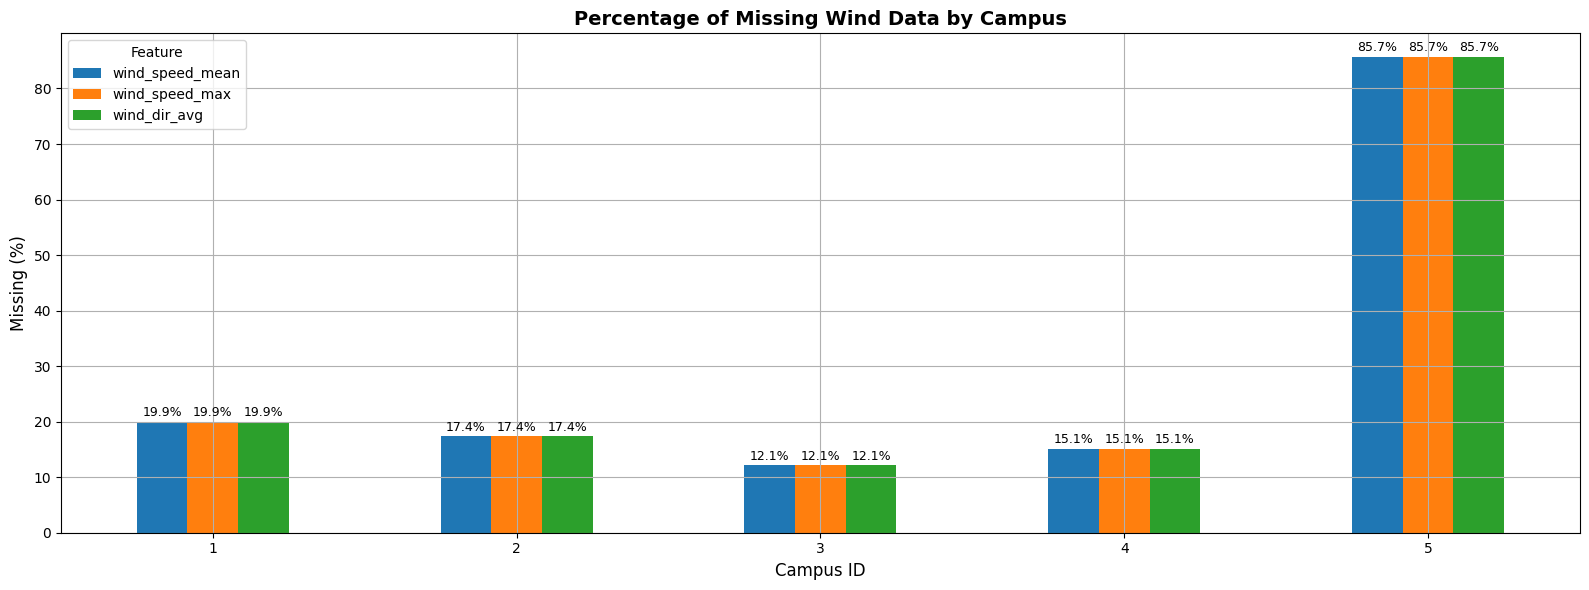

In [17]:
def missing_summary_by_campus(final_dataset_all):
    wind_cols = ["wind_speed_mean", "wind_speed_max", "wind_dir_avg"]

    # Calculate percentage of missing values by campus
    summary = (
        final_dataset_all.groupby("campus_id")[wind_cols]
        .apply(lambda x: x.isna().mean() * 100)  # percentage missing
    )

    # Plot
    ax = summary.plot(kind="bar", figsize=(16, 6))
    plt.title("Percentage of Missing Wind Data by Campus", fontsize=14, weight="bold")
    plt.ylabel("Missing (%)", fontsize=12)
    plt.xlabel("Campus ID", fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title="Feature")

    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9, padding=2)

    plt.tight_layout()
    plt.show()

# Call function
missing_summary_by_campus(final_dataset_all)

In [18]:
# --- Analyze Consecutive Missing Data in Wind Speed -----------------------
# Create a copy and sort by campus and date
final_copy = final_dataset_all.sort_values(['campus_id', 'date'])

# Flag missing wind speed values
final_copy['is_missing'] = final_copy['wind_speed_mean'].isna()

# Group consecutive missing values into runs
final_copy['missing_group'] = (final_copy['is_missing'] != final_copy['is_missing'].shift()).cumsum()

# Aggregate each missing run: start date, end date, number of days
missing_runs = (
    final_copy[final_copy['is_missing']]
    .groupby(['campus_id', 'missing_group'])
    .agg(start_date=('date', 'min'),
         end_date=('date', 'max'),
         n_days=('date', 'count'))
    .reset_index()  # Keep campus_id for reference
)

# Display missing runs sorted by campus and start date
print(missing_runs.sort_values(['campus_id','start_date']))

   campus_id  missing_group start_date   end_date  n_days
0          1              2 2020-12-02 2020-12-12      11
1          1              4 2021-07-01 2022-04-30     304
2          2              6 2021-07-31 2022-04-30     274
3          3              8 2021-10-21 2022-04-30     192
4          4             10 2021-10-16 2022-04-30     197
5          5             12 2021-10-16 2022-04-30     197


### Visualization of Wind Feature Trends and Missing Data

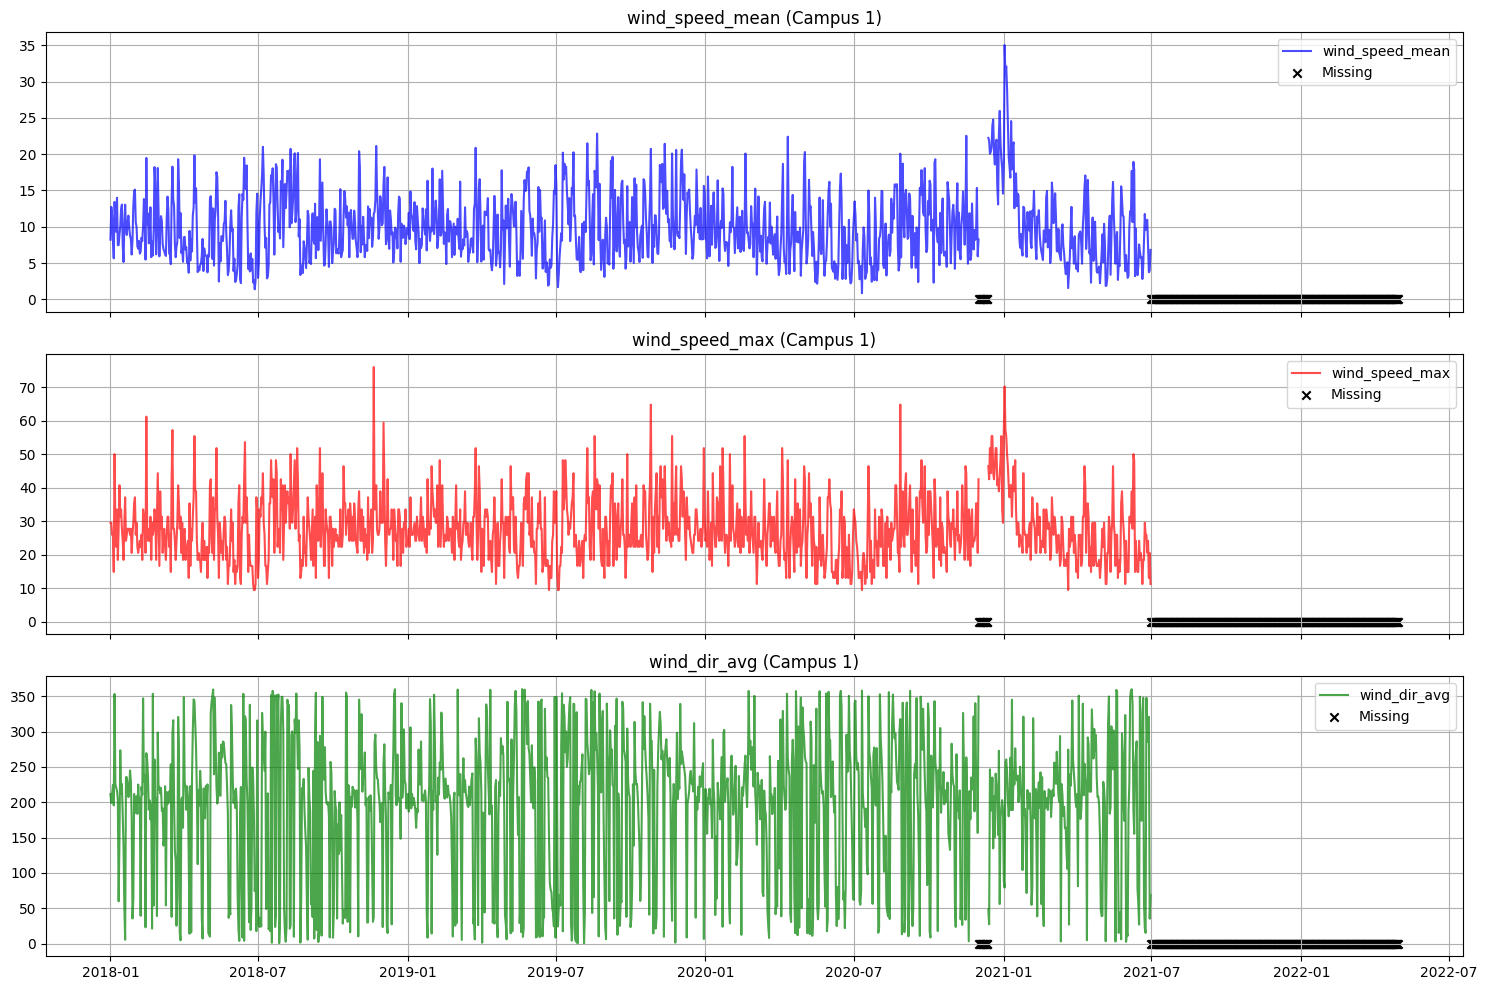

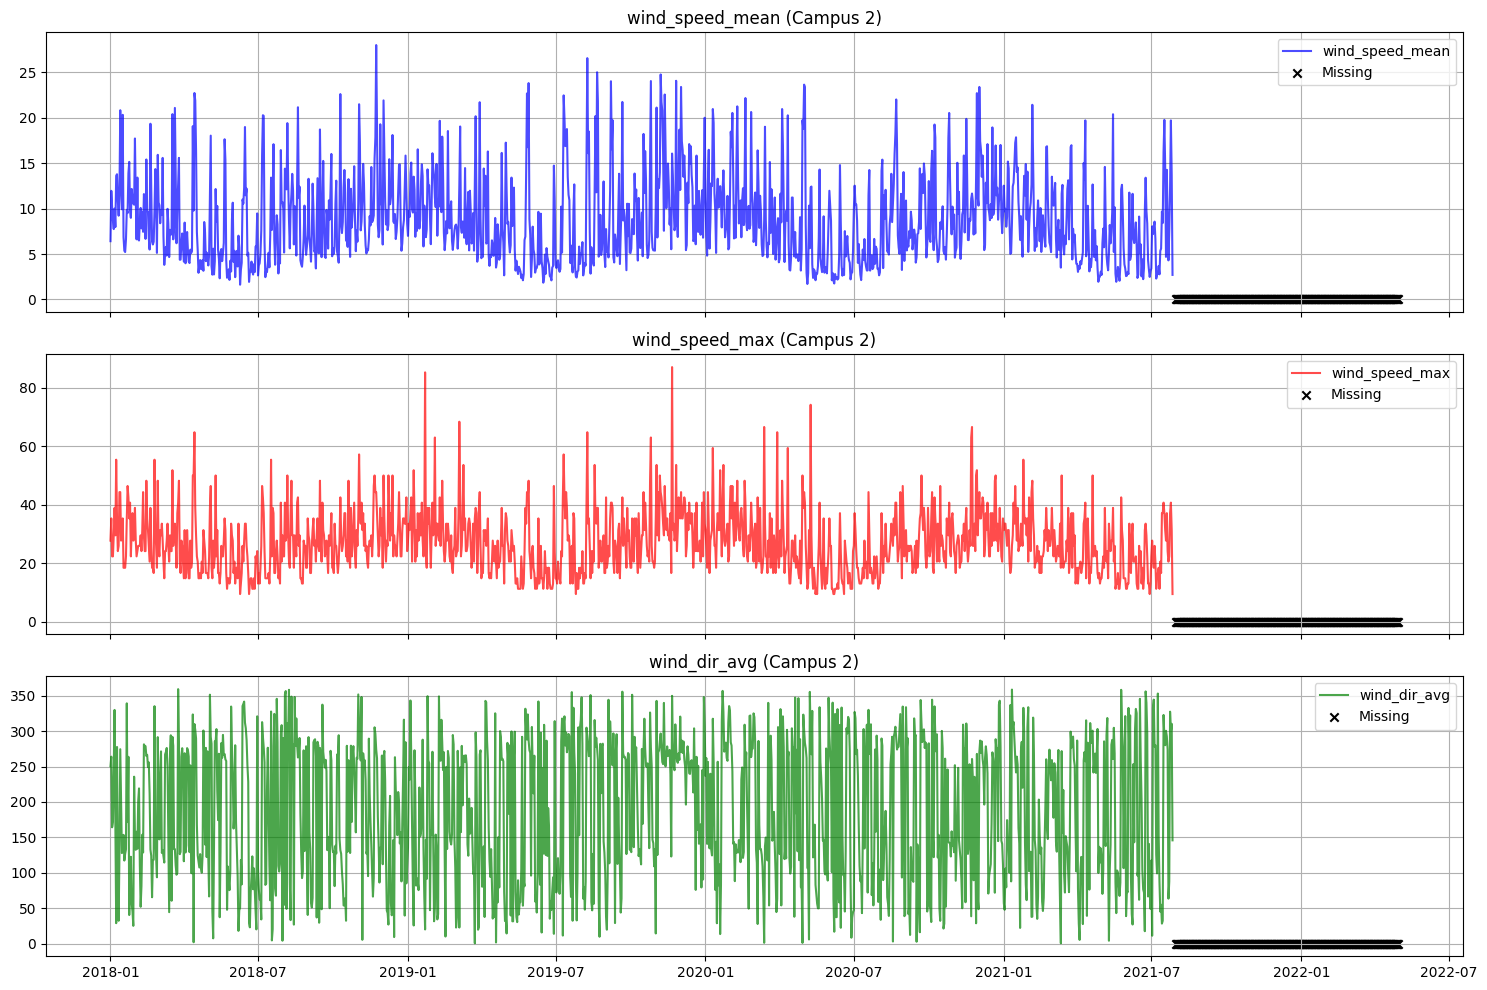

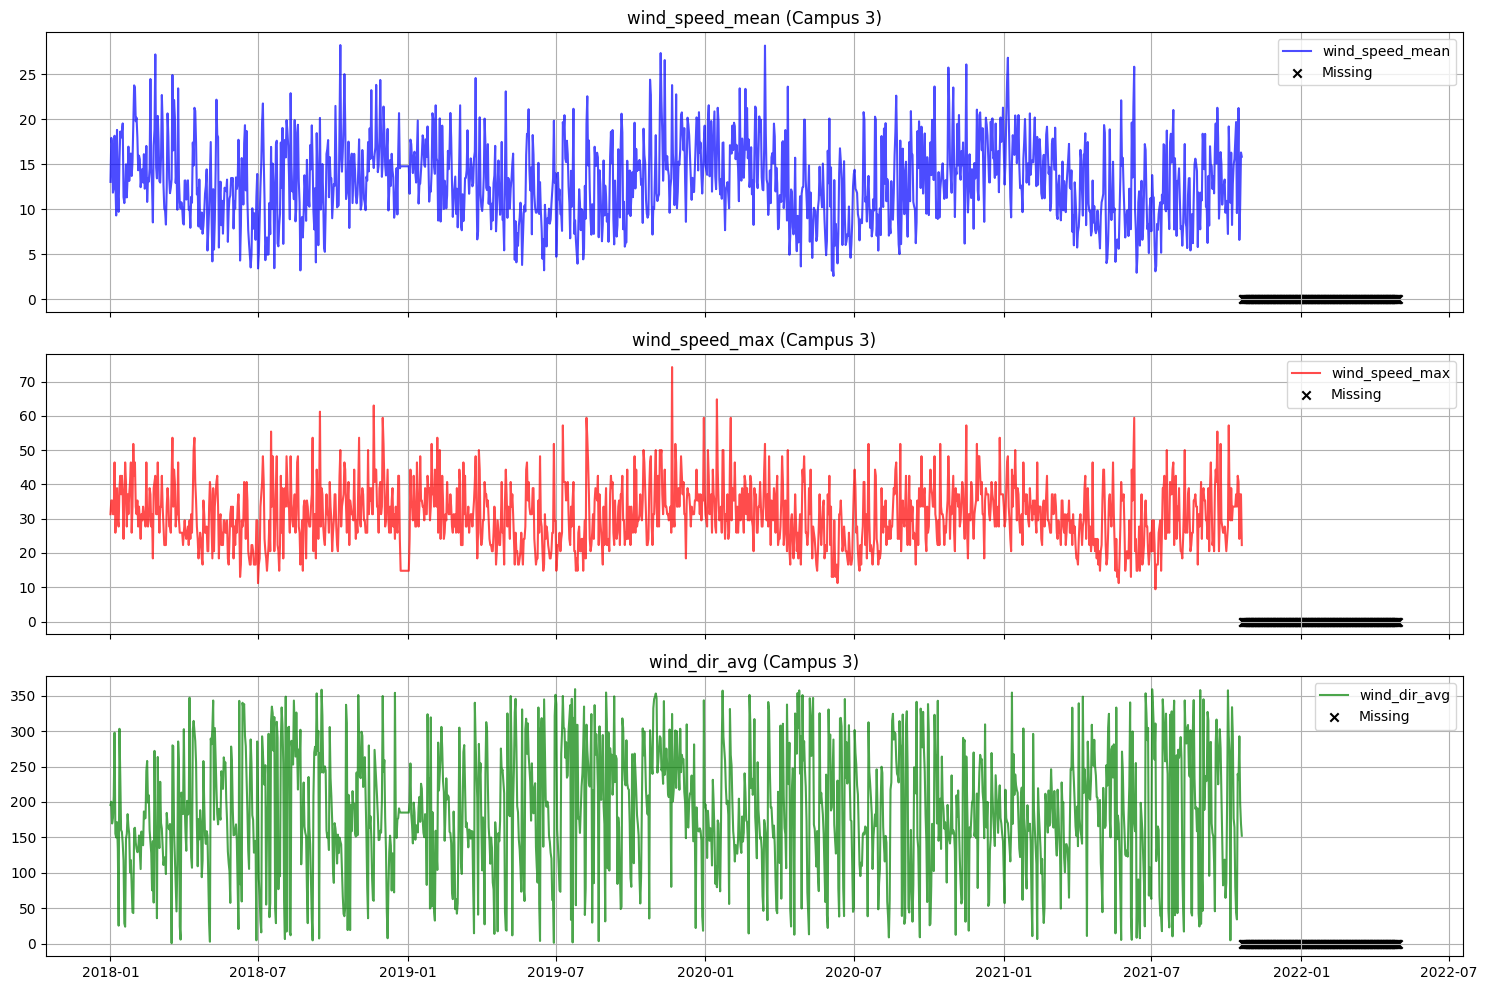

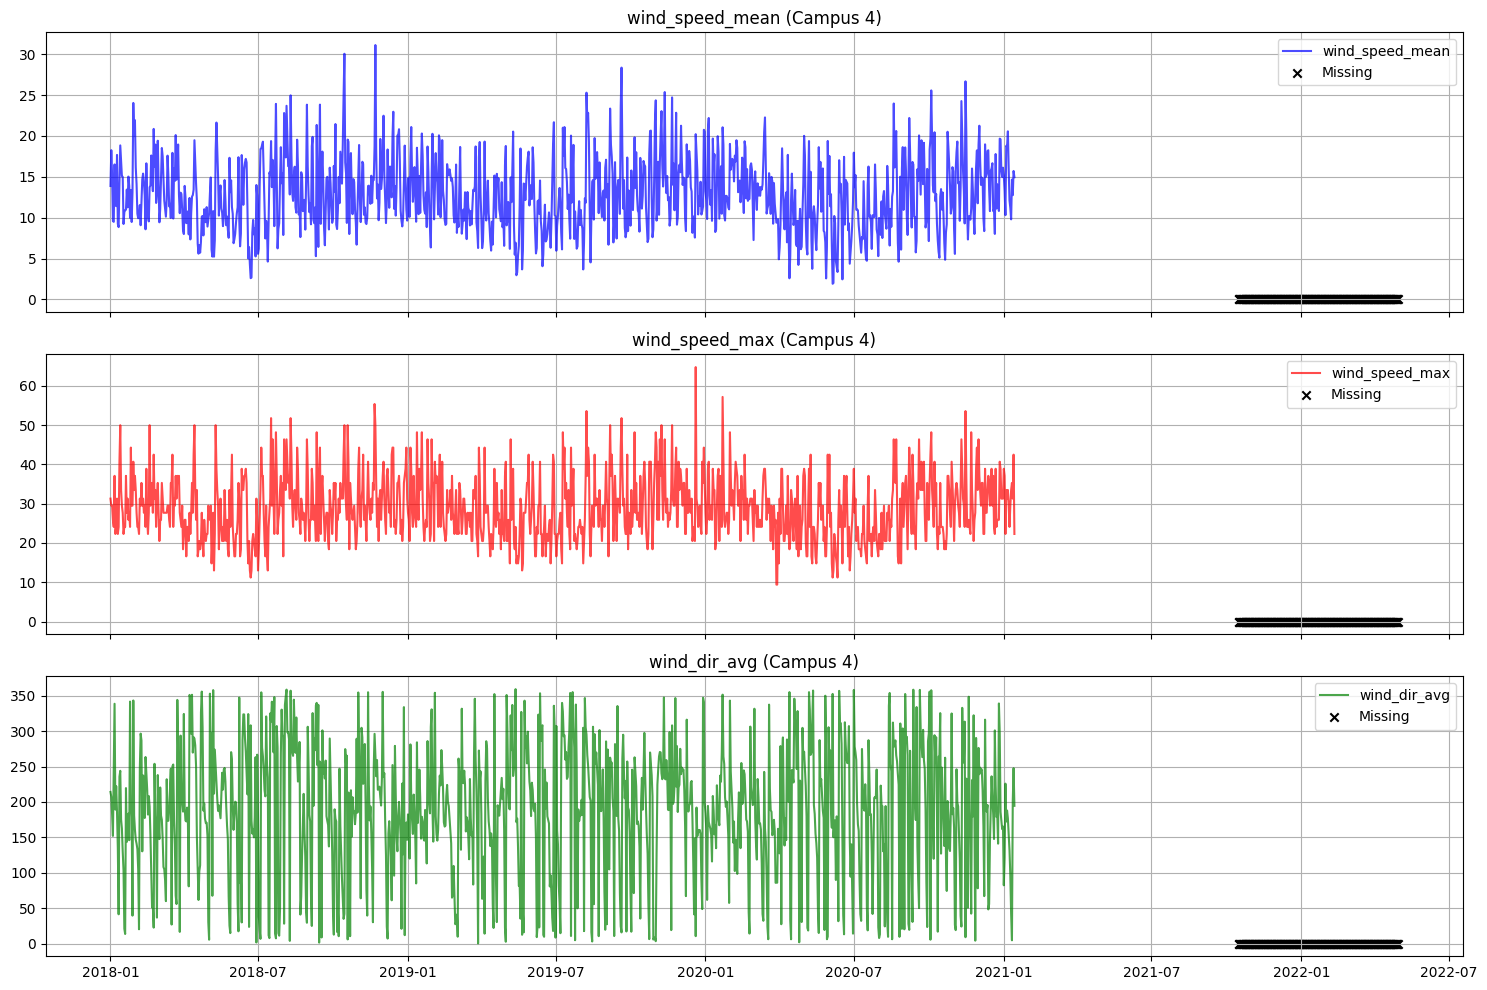

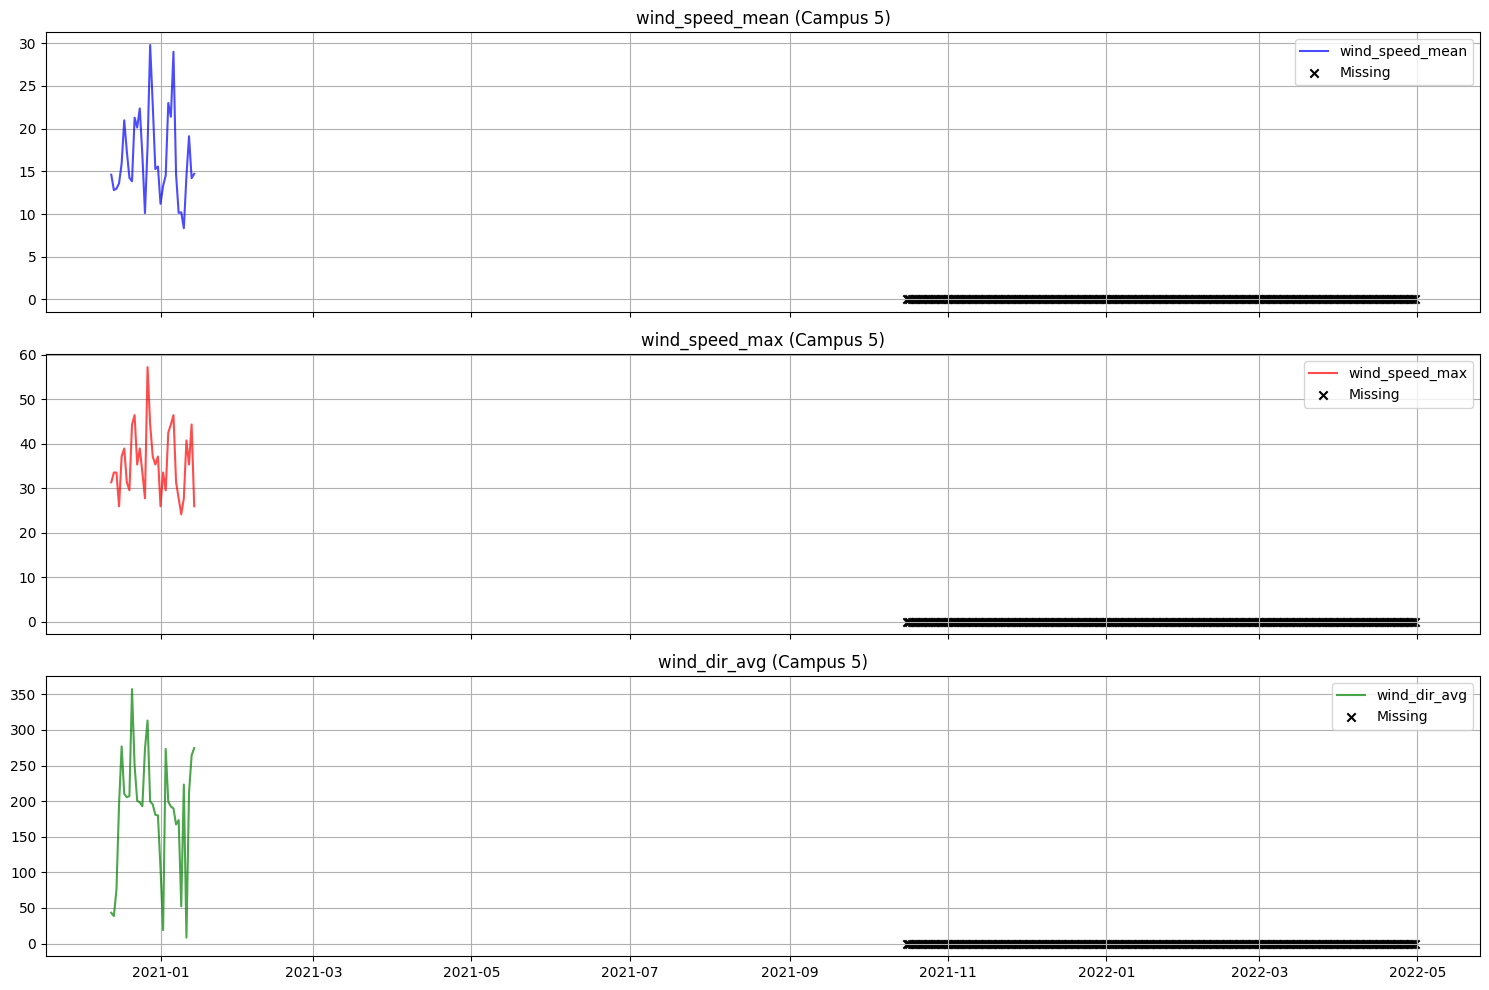

In [19]:
# --- Function to plot wind features and highlight missing values -----------
def plot_wind_features(final_copy, campus_id):
    campus_df = final_copy[final_copy["campus_id"] == campus_id].set_index("date")

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    for ax, col, color in zip(
        axes,
        ["wind_speed_mean", "wind_speed_max", "wind_dir_avg"],
        ["blue", "red", "green"]
    ):
        # Plot the wind feature
        ax.plot(campus_df.index, campus_df[col], color=color, label=col, alpha=0.7)

        # Highlight missing values
        ax.scatter(
            campus_df.index[campus_df[col].isna()],
            [0] * campus_df[col].isna().sum(),
            color="black", marker="x", label="Missing"
        )

        ax.set_title(f"{col} (Campus {campus_id})")
        ax.legend()

    plt.tight_layout()
    plt.show()

# --- Example plots for multiple campuses ---------------------------------
plot_wind_features(final_copy, campus_id=1)
plot_wind_features(final_copy, campus_id=2)
plot_wind_features(final_copy, campus_id=3)
plot_wind_features(final_copy, campus_id=4)
plot_wind_features(final_copy, campus_id=5)

### Time Series Visualization of Missing Data

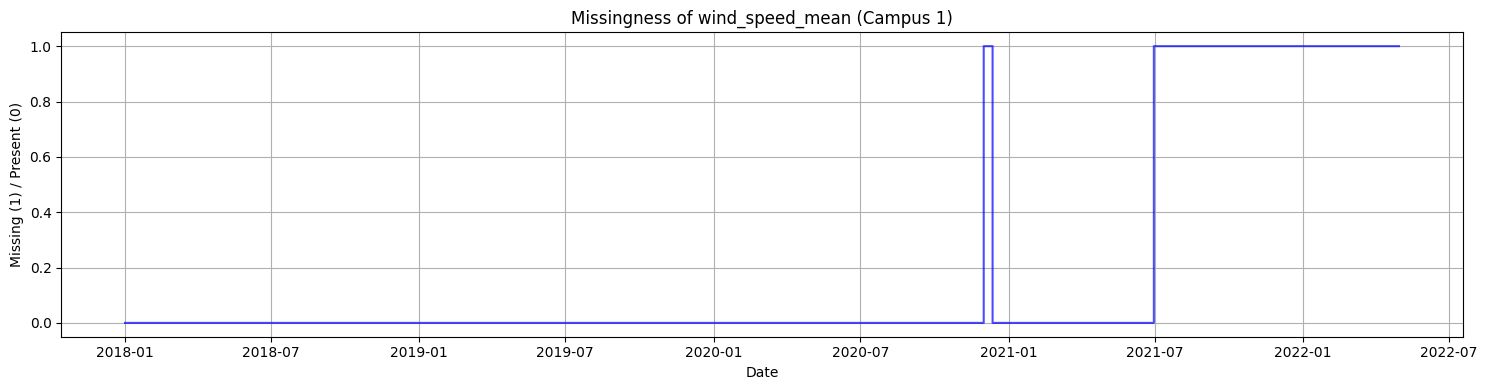

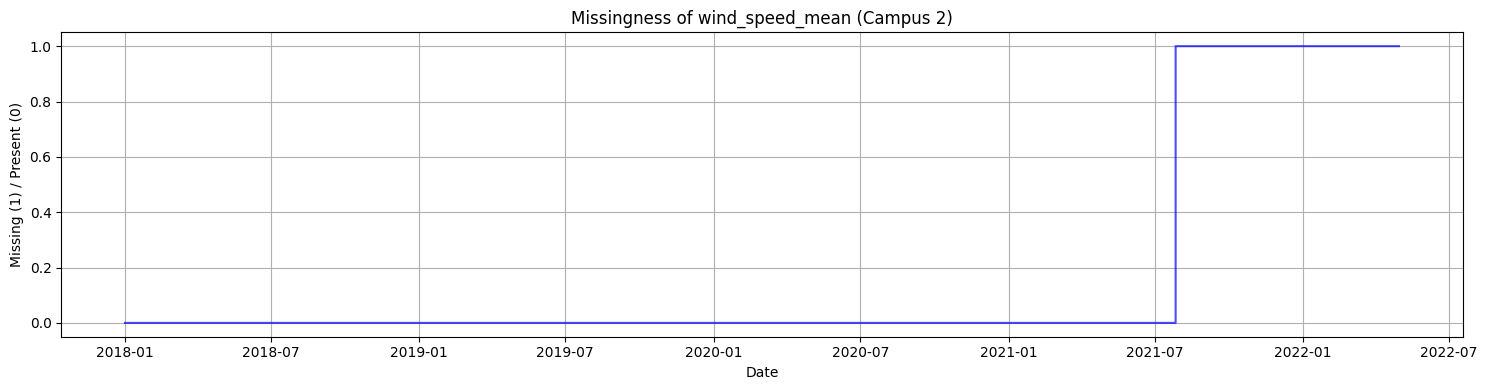

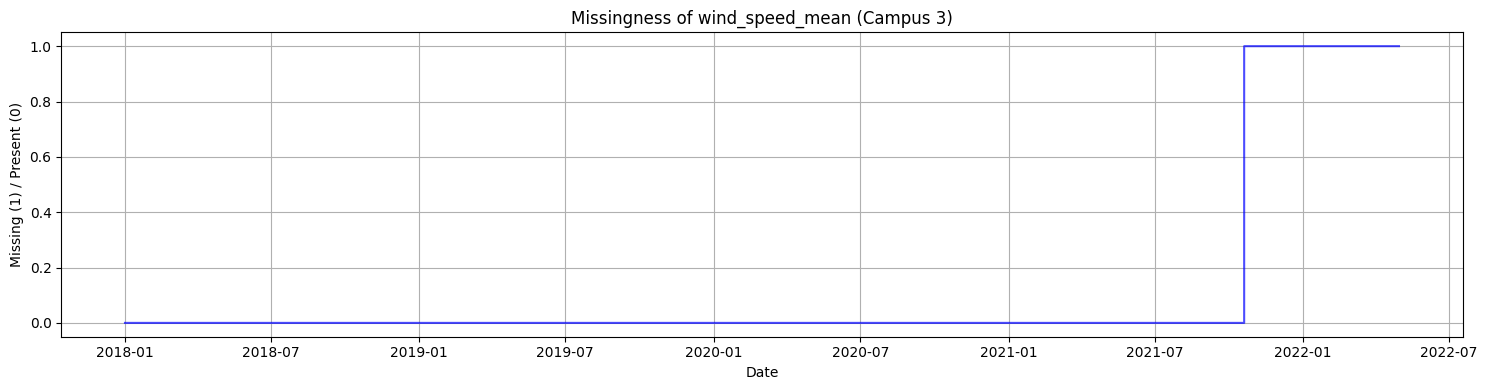

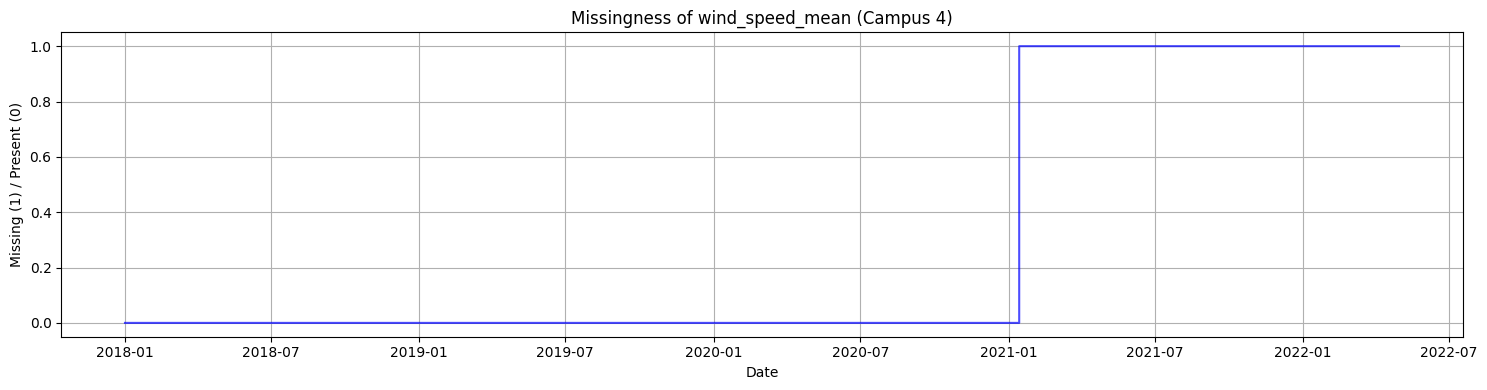

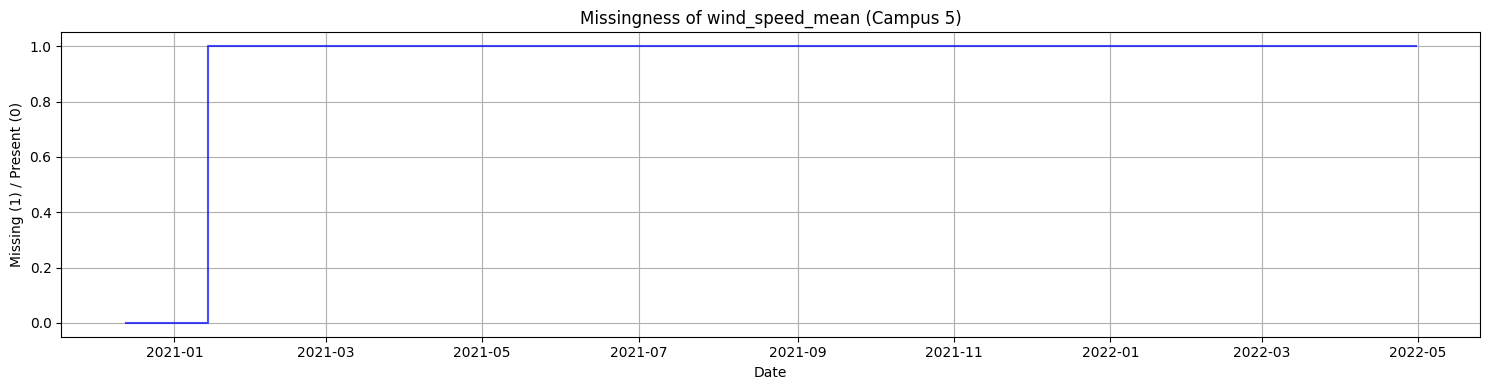

In [20]:
# --- Function to visualize missing data (wind_speed_mean only) ------------
def plot_missing_wind_speed(final_copy, campus_id):
    # Filter data for the selected campus and set date as index
    campus_df = final_copy[final_copy["campus_id"] == campus_id].set_index("date")

    # Create plot
    plt.figure(figsize=(15, 4))
    plt.plot(
        campus_df.index,
        campus_df["wind_speed_mean"].isna().astype(int),
        drawstyle="steps", color="blue", alpha=0.7
    )

    # Add labels and title
    plt.title(f"Missingness of wind_speed_mean (Campus {campus_id})")
    plt.ylabel("Missing (1) / Present (0)")
    plt.xlabel("Date")

    plt.tight_layout()
    plt.show()

# --- Example plots for multiple campuses ---------------------------------
for cid in [1, 2, 3, 4, 5]:
    plot_missing_wind_speed(final_copy, campus_id=cid)

### Correlation Analysis: Wind Features vs. Electricity Consumption

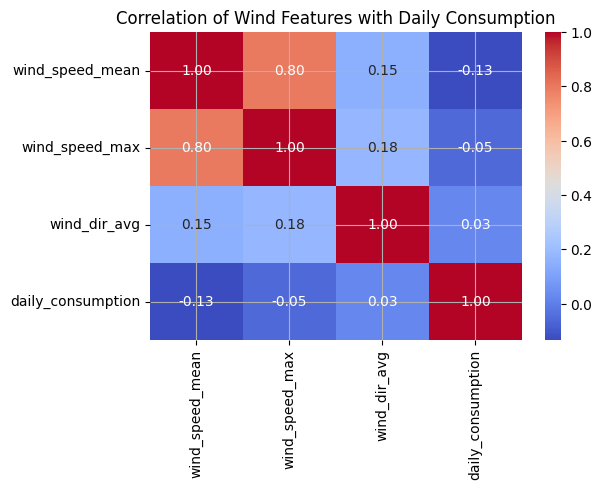

In [21]:
# --- Define Wind Feature Columns -----------------------------------------
wind_cols = ["wind_speed_mean", "wind_speed_max", "wind_dir_avg"]

# --- Compute Correlation with Daily Electricity Consumption --------------
corr = final_copy[wind_cols + ["daily_consumption"]].corr()

# --- Visualize Correlation Matrix ----------------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Wind Features with Daily Consumption")
plt.show()

### Regression Analysis: Wind Features vs. Electricity Consumption

In [22]:
# --- Prepare Dataset for Regression --------------------------------------
subset = final_copy[wind_cols + ["daily_consumption"]].dropna()

X = subset[wind_cols]
X = sm.add_constant(X)  # add intercept
y = subset["daily_consumption"]

# --- Fit Ordinary Least Squares (OLS) Regression -------------------------
model = sm.OLS(y, X).fit()

# Display regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      daily_consumption   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     47.14
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           4.82e-30
Time:                        18:32:54   Log-Likelihood:                -60296.
No. Observations:                5102   AIC:                         1.206e+05
Df Residuals:                    5098   BIC:                         1.206e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.532e+04   1609.345     

### Feature Importance Using Random Forest

In [23]:
# --- Prepare Dataset ------------------------------------------------------
subset = final_copy[wind_cols + ["daily_consumption"]].dropna()

X = subset[wind_cols]
y = subset["daily_consumption"]

# --- Handle Missing Values ------------------------------------------------
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# --- Fit Random Forest Regressor -----------------------------------------
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_imputed, y)

# --- Extract and Display Feature Importances -----------------------------
importance = model.feature_importances_
for col, imp in zip(wind_cols, importance):
    print(f"{col}: {imp:.4f}")

wind_speed_mean: 0.3808
wind_speed_max: 0.1482
wind_dir_avg: 0.4710


### Removal of Low-Value Features: Wind Variables

---


Considering the high proportion of missing data, its systematic temporal clustering, and the low predictive power of wind-related features, the decision was made to remove these variables from the dataset. This approach prevents bias, maximizes the usable dataset size, and ensures that downstream models are not adversely affected by weak or unreliable predictors.


---



In [24]:
# --- Columns to drop due to low predictive value and high missingness -------
wind_cols = ["wind_speed_mean", "wind_speed_max", "wind_dir_avg"]

# Remove them from the dataset
final_dataset_all = final_dataset_all.drop(columns=wind_cols)

# Display remaining columns
print("Remaining columns:", final_dataset_all.columns.tolist())

Remaining columns: ['campus_id', 'date', 'apparent_temp_mean', 'air_temp_mean', 'air_temp_min', 'air_temp_max', 'dew_point_mean', 'humidity_mean', 'humidity_min', 'humidity_max', 'daily_consumption', 'is_holiday', 'is_semester', 'is_exam', 'campus_name', 'campus_capacity', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'season', 'cdd_18', 'hdd_18', 'consumption_per_capacity']


In [25]:
# --- Display first few rows of the final preprocessed dataset -------------
final_dataset_all.head()

campus_id       date  apparent_temp_mean  air_temp_mean  air_temp_min  \
0          1 2018-01-01           18.536667      19.368125          14.7   
1          1 2018-01-02           16.538681      18.711736          16.1   
2          1 2018-01-03           15.476597      17.523264          13.5   
3          1 2018-01-04           17.361875      18.491944          10.7   
4          1 2018-01-05           21.963333      22.298056          13.1   

   air_temp_max  dew_point_mean  humidity_mean  humidity_min  humidity_max  \
0          27.3       12.392014      67.898611          33.0          99.0   
1          23.7       10.877708      61.620833          39.0          80.0   
2          23.4       10.295417      66.134028          23.0         100.0   
3          26.7       11.472500      66.411806          32.0          99.0   
4          32.6       12.436319      60.009028          24.0         100.0   

   daily_consumption  is_holiday  is_semester  is_exam campus_name  \
0          69504.087         1.0            0        0    Bundoora   
1          78370.296         0.0            1        0    Bundoora   
2          77899.058         0.0            1        0    Bundoora   
3          81222.729         0.0            1        0    Bundoora   
4          85270.167         0.0            1        0    Bundoora   

   campus_capacity  year  month  day  day_of_week  is_weekend  season  \
0            26000  2018      1    1            0           0  Summer   
1            26000  2018      1    2            1           0  Summer   
2            26000  2018      1    3            2           0  Summer   
3            26000  2018      1    4            3           0  Summer   
4            26000  2018      1    5            4           0  Summer   

     cdd_18    hdd_18  consumption_per_capacity  
0  1.368125  0.000000                  2.673234  
1  0.711736  0.000000                  3.014242  
2  0.000000  0.476736                  2.996118  
3  0.491944  0.000000                  3.123951  
4  4.298056  0.000000                  3.279622

In [26]:
# --- Display final dataset info ------------------------------------------
final_dataset_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   campus_id                 6277 non-null   int64         
 1   date                      6277 non-null   datetime64[ns]
 2   apparent_temp_mean        6277 non-null   float64       
 3   air_temp_mean             6277 non-null   float64       
 4   air_temp_min              6277 non-null   float64       
 5   air_temp_max              6277 non-null   float64       
 6   dew_point_mean            6277 non-null   float64       
 7   humidity_mean             6277 non-null   float64       
 8   humidity_min              6277 non-null   float64       
 9   humidity_max              6277 non-null   float64       
 10  daily_consumption         6277 non-null   float64       
 11  is_holiday                6277 non-null   float64       
 12  is_semester         

In [27]:
# --- Create a copy of the final preprocessed dataset for analysis ----------
df = final_dataset_all.copy()

# 3. Exploratory Data Analysis (EDA)

## Statistical Summary of Numerical Features

In [28]:
# --- Generate descriptive statistics for numerical columns ---------------
df.describe()

campus_id                           date  apparent_temp_mean  \
count  6277.000000                           6277         6277.000000   
mean      2.526366  2020-03-04 03:18:40.089214464           13.777284   
min       1.000000            2018-01-01 00:00:00           -0.247014   
25%       1.000000            2019-01-28 00:00:00            8.068472   
50%       2.000000            2020-02-24 00:00:00           13.179514   
75%       3.000000            2021-04-03 00:00:00           18.864792   
max       5.000000            2022-04-30 00:00:00           34.676319   
std       1.178797                            NaN            6.806227   

       air_temp_mean  air_temp_min  air_temp_max  dew_point_mean  \
count    6277.000000   6277.000000   6277.000000     6277.000000   
mean       16.278209      9.889485     23.088784        7.967026   
min         3.026181     -3.100000      6.800000       -6.747639   
25%        11.011875      5.500000     16.600000        5.106597   
50%        15.878819      9.800000     22.300000        7.509375   
75%        20.810764     13.900000     28.700000       10.499722   
max        37.687639     30.400000     46.600000       22.213208   
std         6.341376      5.680954      7.643452        4.133446   

       humidity_mean  humidity_min  humidity_max  daily_consumption  \
count    6277.000000   6277.000000   6277.000000        6277.000000   
mean       64.508583     38.649195     88.404652       22347.338400   
min        12.153472      2.000000     25.000000           4.736000   
25%        51.103472     24.000000     81.000000        1374.208000   
50%        66.346528     37.000000     95.000000        4611.160000   
75%        78.881356     51.000000    100.000000       43574.035000   
max       100.000000    100.000000    100.000000      105789.235000   
std        18.271682     18.352219     14.327167       32379.746595   

        is_holiday  is_semester      is_exam  campus_capacity         year  \
count  6277.000000  6277.000000  6277.000000      6277.000000  6277.000000   
mean      0.048112     0.177155     0.073921      8138.903935  2019.696352   
min       0.000000     0.000000     0.000000       500.000000  2018.000000   
25%       0.000000     0.000000     0.000000       800.000000  2019.000000   
50%       0.000000     0.000000     0.000000      5000.000000  2020.000000   
75%       0.000000     0.000000     0.000000     26000.000000  2021.000000   
max       1.000000     1.000000     1.000000     26000.000000  2022.000000   
std       0.214020     0.381830     0.261663     10515.178107     1.286992   

             month          day  day_of_week   is_weekend       cdd_18  \
count  6277.000000  6277.000000  6277.000000  6277.000000  6277.000000   
mean      6.244544    15.726621     2.997770     0.285487     1.896031   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%       3.000000     8.000000     1.000000     0.000000     0.000000   
50%       6.000000    16.000000     3.000000     0.000000     0.000000   
75%       9.000000    23.000000     5.000000     1.000000     2.810764   
max      12.000000    31.000000     6.000000     1.000000    19.687639   
std       3.570817     8.790411     1.999999     0.451682     3.296733   

            hdd_18  consumption_per_capacity  
count  6277.000000               6277.000000  
mean      3.617822                  2.389282  
min       0.000000                  0.006292  
25%       0.000000                  1.390334  
50%       2.121181                  2.290938  
75%       6.988125                  3.142259  
max      14.973819                  7.885951  
std       3.952645                  1.286827

## Exploring Categorical Data

### Date Parsing and Sorting

In [29]:
# --- Convert 'date' column to datetime format ----------------------------
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# --- Sort dataset by date and reset index --------------------------------
df = df.sort_values('date').reset_index(drop=True)

In [30]:
# --- Convert 'is_holiday' to integer -------------------------------------
df['is_holiday'] = df['is_holiday'].astype(int)

# --- Define categorical columns ------------------------------------------
categorical_cols = [
    'campus_id', 'is_holiday', 'is_semester', 'is_exam',
    'day_of_week', 'is_weekend', 'season', 'month'
]

# --- Convert categorical columns to 'category' dtype ---------------------
for col in categorical_cols:
    df[col] = df[col].astype('category')

# --- Check updated data types --------------------------------------------
print(df.dtypes)

campus_id                         category
date                        datetime64[ns]
apparent_temp_mean                 float64
air_temp_mean                      float64
air_temp_min                       float64
air_temp_max                       float64
dew_point_mean                     float64
humidity_mean                      float64
humidity_min                       float64
humidity_max                       float64
daily_consumption                  float64
is_holiday                        category
is_semester                       category
is_exam                           category
campus_name                         object
campus_capacity                      int64
year                                 int32
month                             category
day                                  int32
day_of_week                       category
is_weekend                        category
season                            category
cdd_18                             float64
hdd_18     

### Analysis of Categorical Variables

In [31]:
# --- Define custom styles for DataFrame display --------------------------
styles = [
    {'selector': 'th', 'props': [('font-size', '110%'), ('text-align', 'center')]},  # Header
    {'selector': 'td', 'props': [('font-size', '105%'), ('text-align', 'center')]}   # Cells
]

# --- Identify categorical columns ----------------------------------------
categorical_cols = df.select_dtypes(include='category').columns
print("\nValue Counts for Categorical Columns in df DataFrame:")

# --- Display value counts for each categorical column --------------------
for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    value_counts_df = df[col].value_counts().reset_index()
    value_counts_df.columns = [col, 'Count']
    styled_df = value_counts_df.style.set_table_styles(styles)
    display(styled_df)  # Use display() in Jupyter Notebook

# --- Convert selected categorical columns to integer dtype ----------------
cols = [
    'is_holiday', 'is_semester', 'is_exam',
    'is_weekend', 'day_of_week', 'month'
]

for col in cols:
    df[col] = df[col].astype('int')


Value Counts for Categorical Columns in df DataFrame:

Value Counts for campus_id:



Value Counts for is_holiday:



Value Counts for is_semester:



Value Counts for is_exam:



Value Counts for month:



Value Counts for day_of_week:



Value Counts for is_weekend:



Value Counts for season:


## Distribution of Daily Energy Consumption

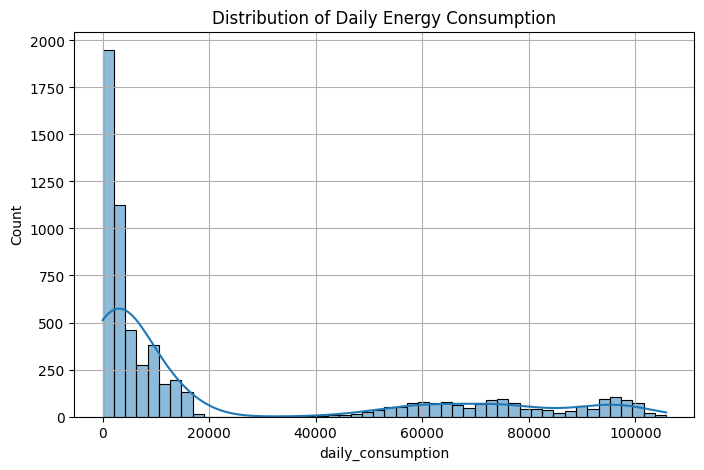

In [32]:
# --- Distribution of daily consumption ----------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df["daily_consumption"], bins=50, kde=True)
plt.title("Distribution of Daily Energy Consumption")
plt.show()

## Time Series Analysis: Daily Consumption Trends

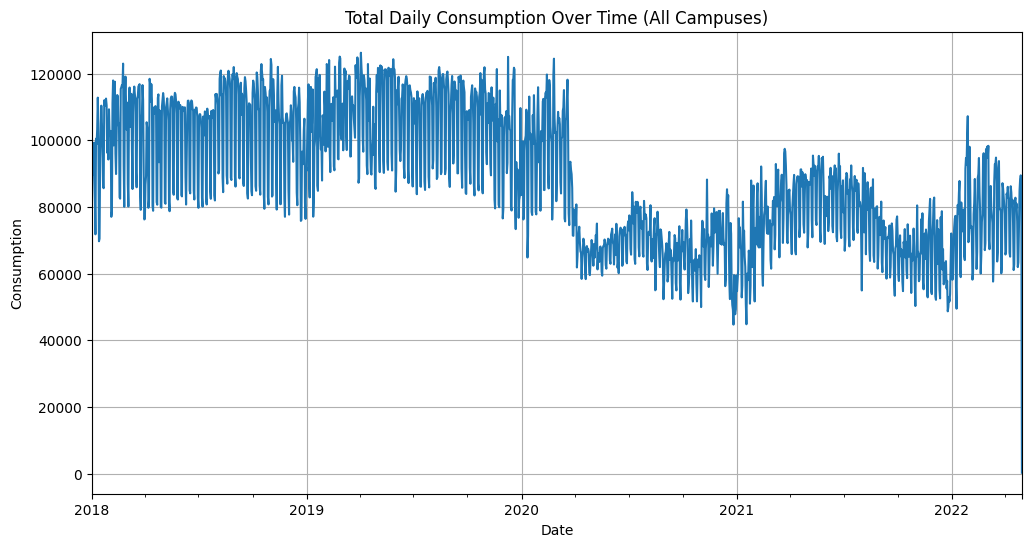

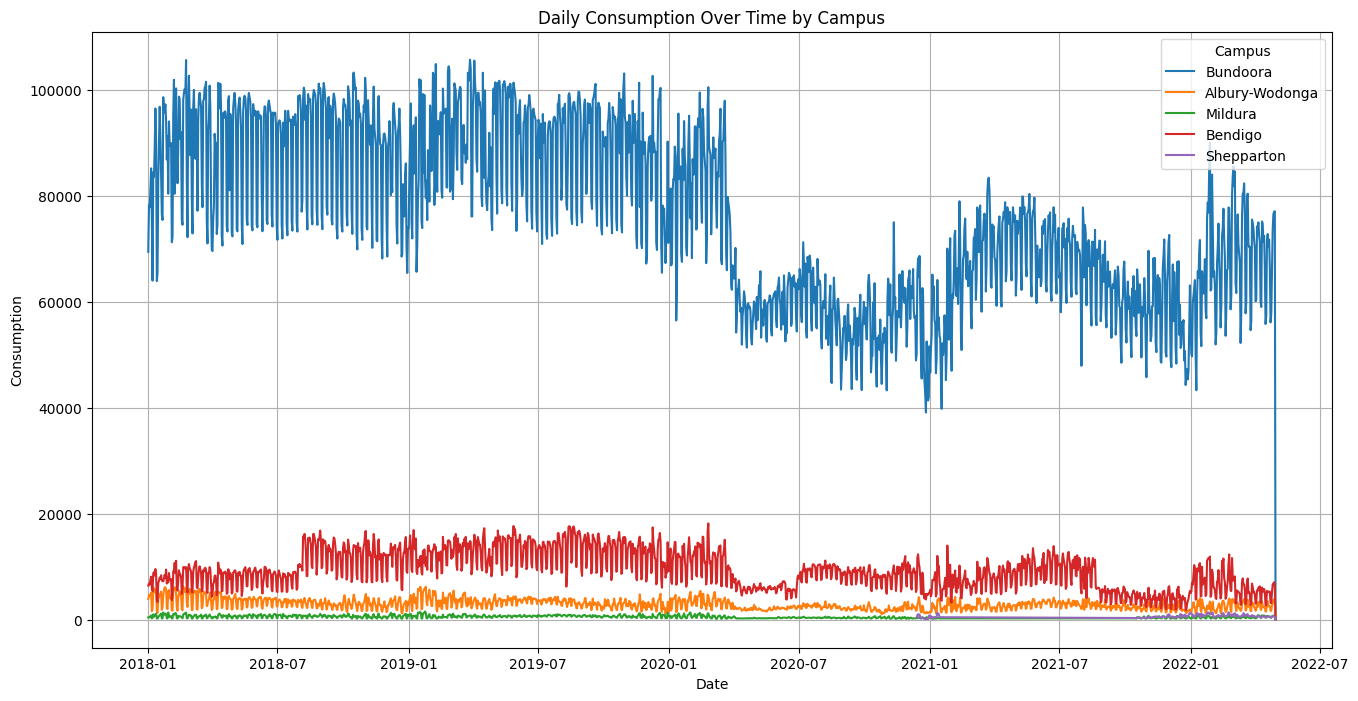

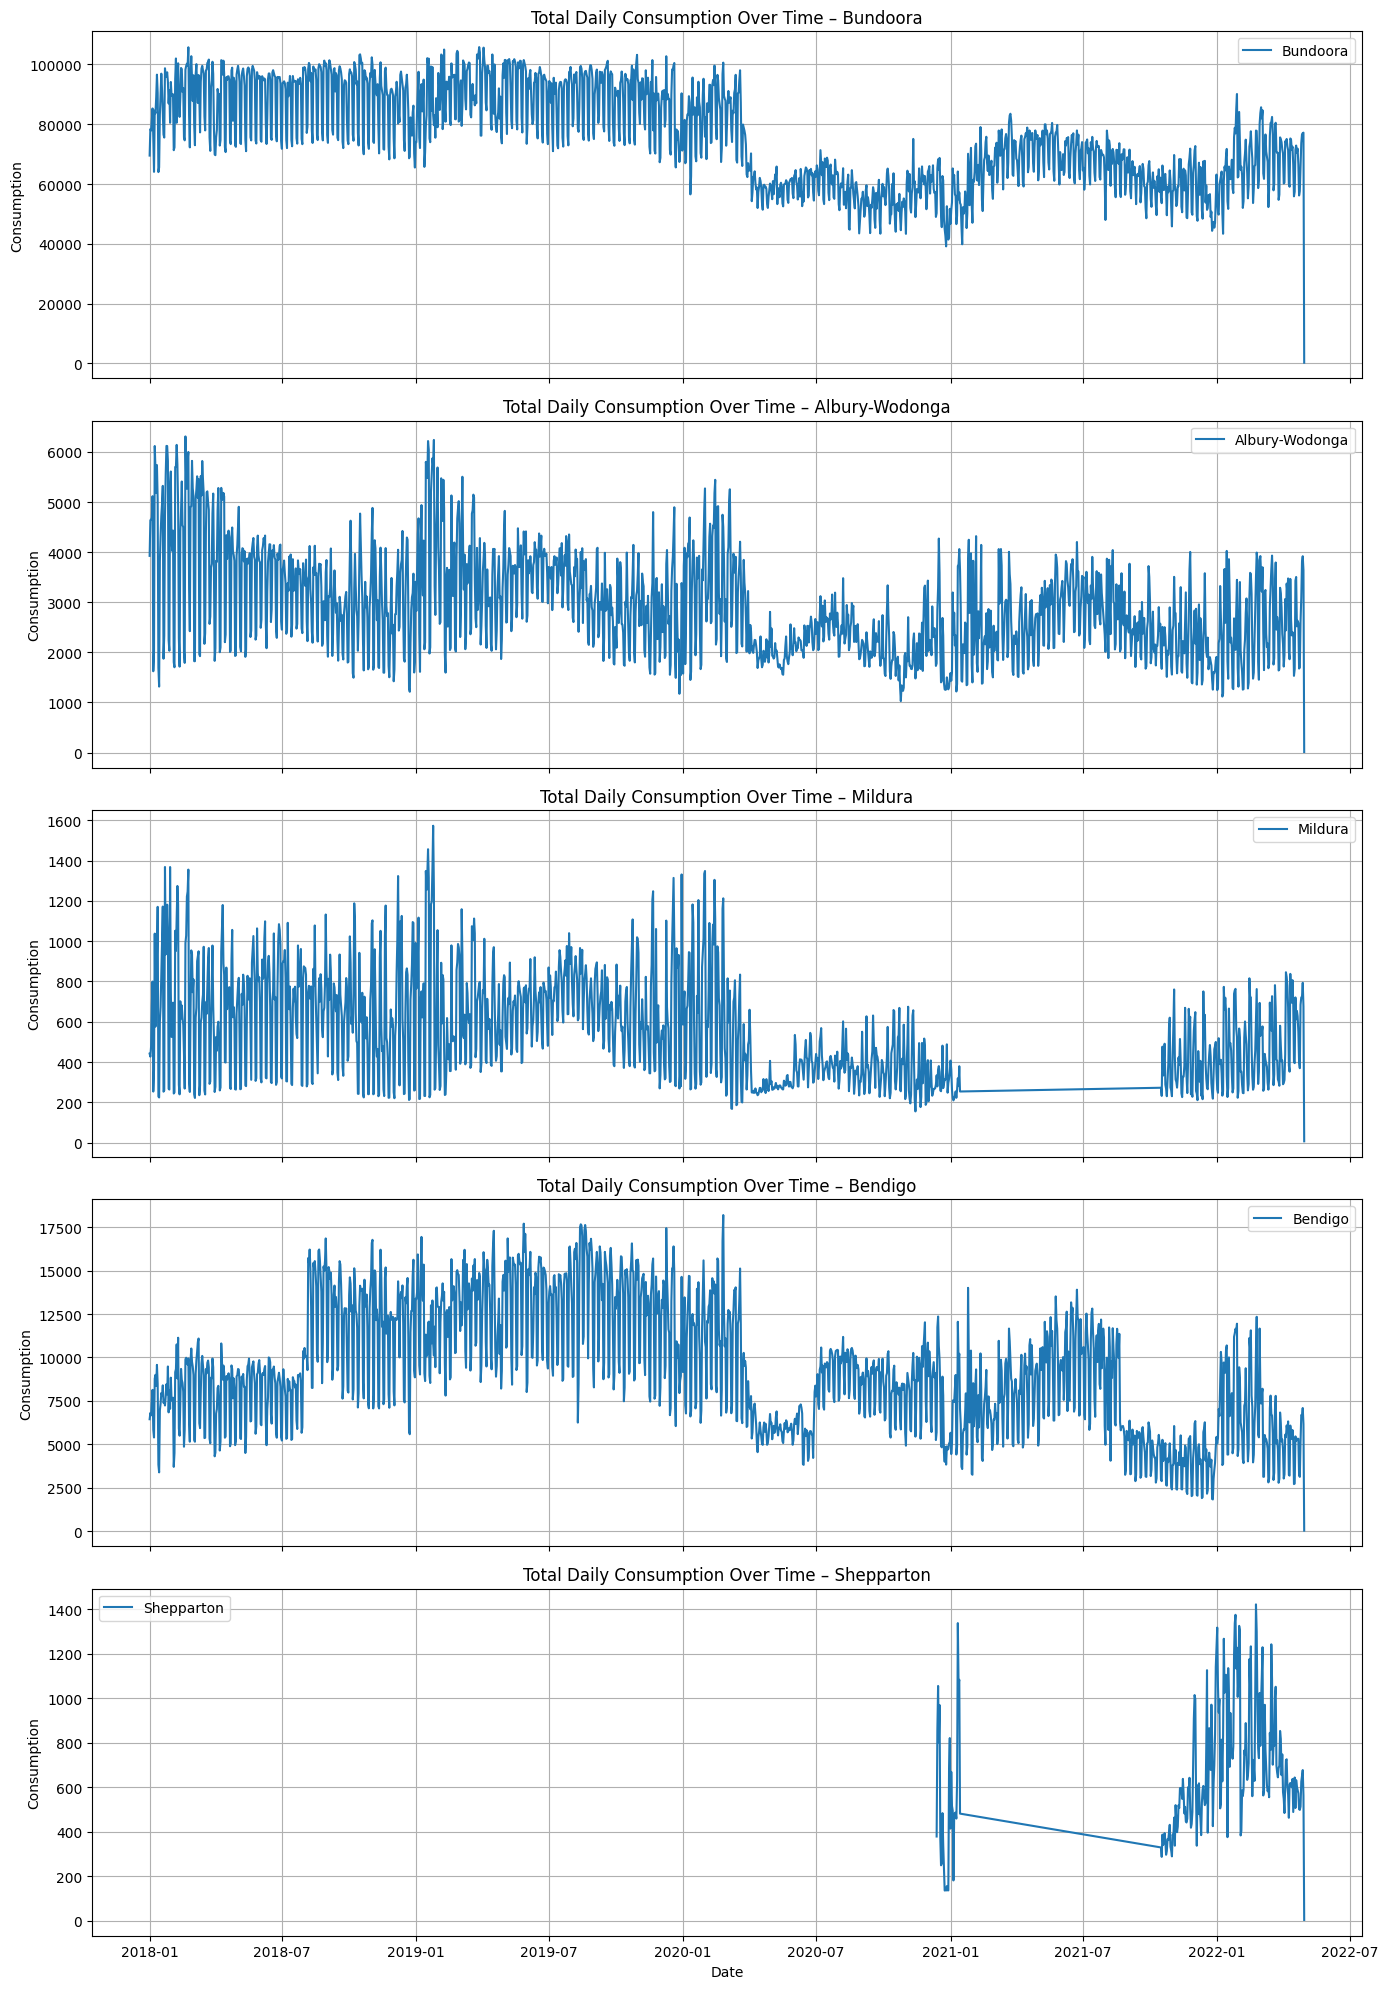

In [33]:
# --- Total Daily Consumption Over Time (all campuses) -------------------
plt.figure(figsize=(12,6))
df.groupby("date")["daily_consumption"].sum().plot()
plt.title("Total Daily Consumption Over Time (All Campuses)")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.show()

# --- Daily Consumption Over Time by Campus (all campuses on same chart) -
plt.figure(figsize=(16,8))
for campus in df["campus_name"].unique():
    campus_data = df[df["campus_name"] == campus].groupby("date")["daily_consumption"].sum()
    plt.plot(campus_data.index, campus_data.values, label=campus)

plt.title("Daily Consumption Over Time by Campus")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend(title="Campus")
plt.show()

# --- Total Daily Consumption Over Time (each campus separately) ---------
campuses = df["campus_name"].unique()
fig, axes = plt.subplots(len(campuses), 1, figsize=(14, 4*len(campuses)), sharex=True)

for i, campus in enumerate(campuses):
    campus_data = df[df["campus_name"] == campus].groupby("date")["daily_consumption"].sum()
    axes[i].plot(campus_data.index, campus_data.values, label=campus, color="tab:blue")
    axes[i].set_title(f"Total Daily Consumption Over Time – {campus}")
    axes[i].set_ylabel("Consumption")
    axes[i].legend()

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

## Time Series Analysis: Consumption per Capacity Trends

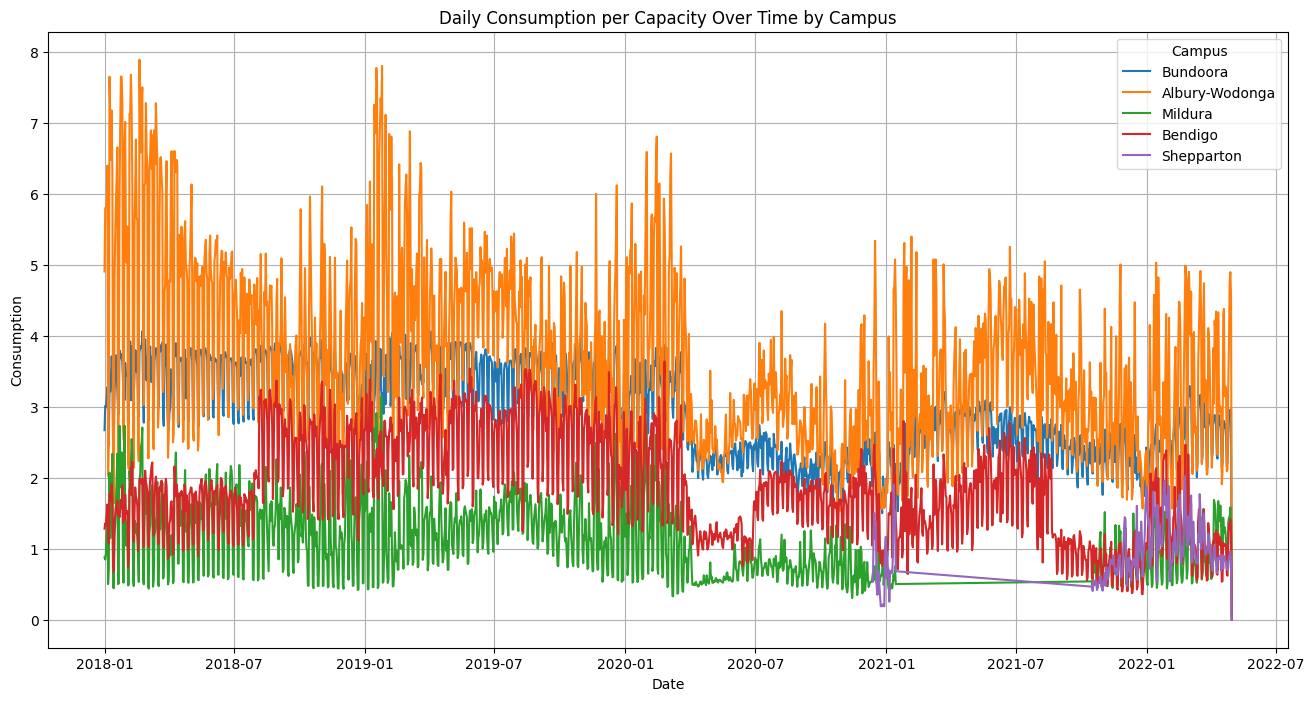

In [34]:
# --- Daily Consumption per Capacity Over Time by Campus (all campuses on same chart) -
plt.figure(figsize=(16,8))
for campus in df["campus_name"].unique():
    campus_data = df[df["campus_name"] == campus].groupby("date")["consumption_per_capacity"].sum()
    plt.plot(campus_data.index, campus_data.values, label=campus)

plt.title("Daily Consumption per Capacity Over Time by Campus")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend(title="Campus")
plt.show()

## Campus-Level Consumption Summary

In [35]:
# --- Campus-Level Consumption Summary -----------------------------------
if 'campus_name' in df.columns:
    # Compute consumption statistics per campus
    campus_summary = (
        df.groupby('campus_name')['daily_consumption']
        .agg(['count','mean','median','min','max'])
        .sort_values('mean', ascending=False)
        .reset_index()
    )

    # Merge with campus metadata for capacity info
    campus_summary = campus_summary.merge(
        campus_meta[['id', 'name', 'capacity']],
        left_on='campus_name',
        right_on='name',
        how='left'
    )

    # Clean and rename columns for clarity
    campus_summary = campus_summary.rename(columns={'name': 'campus_name_meta',
                                                    'capacity': 'campus_capacity_meta',
                                                    'id': 'campus_id_meta'})
    campus_summary = campus_summary.drop(columns=['campus_name_meta', 'campus_id_meta'])
    campus_summary = campus_summary[['campus_name','campus_capacity_meta','count','mean','median','min','max']]
    campus_summary = campus_summary.rename(columns={'campus_capacity_meta': 'campus_capacity'})

    display(campus_summary)

campus_name  campus_capacity  count          mean     median      min  \
0        Bundoora            26000   1581  75975.100538  74582.562  235.509   
1         Bendigo             5000   1581   9275.072253   9021.024   31.460   
2  Albury-Wodonga              800   1578   2918.751825   2741.620   10.976   
3      Shepparton              700    230    671.242087    616.656    4.736   
4         Mildura              500   1307    561.242461    518.640    7.032   

          max  
0  105789.235  
1   18198.291  
2    6308.761  
3    1421.056  
4    1572.843

## Campus-Level Consumption per Capacity Summary

In [36]:
# --- Campus-Level Consumption per Capacity Summary -----------------------------------
if 'campus_name' in df.columns:
    # Compute consumption per capacity statistics per campus
    campus_summary = (
        df.groupby('campus_name')['consumption_per_capacity']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .sort_values('mean', ascending=False)
        .reset_index()
    )

    # Merge with campus metadata for capacity info
    campus_summary = campus_summary.merge(
        campus_meta[['id', 'name', 'capacity']],
        left_on='campus_name',
        right_on='name',
        how='left'
    )

    # Clean and rename columns for clarity
    campus_summary = campus_summary.rename(columns={'name': 'campus_name_meta',
                                                    'capacity': 'campus_capacity_meta',
                                                    'id': 'campus_id_meta'})
    campus_summary = campus_summary.drop(columns=['campus_name_meta', 'campus_id_meta'])
    campus_summary = campus_summary[['campus_name', 'campus_capacity_meta', 'count', 'mean', 'median', 'min', 'max']]
    campus_summary = campus_summary.rename(columns={'campus_capacity_meta': 'campus_capacity'})

    display(campus_summary)

campus_name  campus_capacity  count      mean    median       min  \
0  Albury-Wodonga              800   1578  3.648440  3.427025  0.013720   
1        Bundoora            26000   1581  2.922119  2.868560  0.009058   
2         Bendigo             5000   1581  1.855014  1.804205  0.006292   
3         Mildura              500   1307  1.122485  1.037280  0.014064   
4      Shepparton              700    230  0.958917  0.880937  0.006766   

        max  
0  7.885951  
1  4.068817  
2  3.639658  
3  3.145686  
4  2.030080

## Relationship Between Air Temperature and Daily Consumption

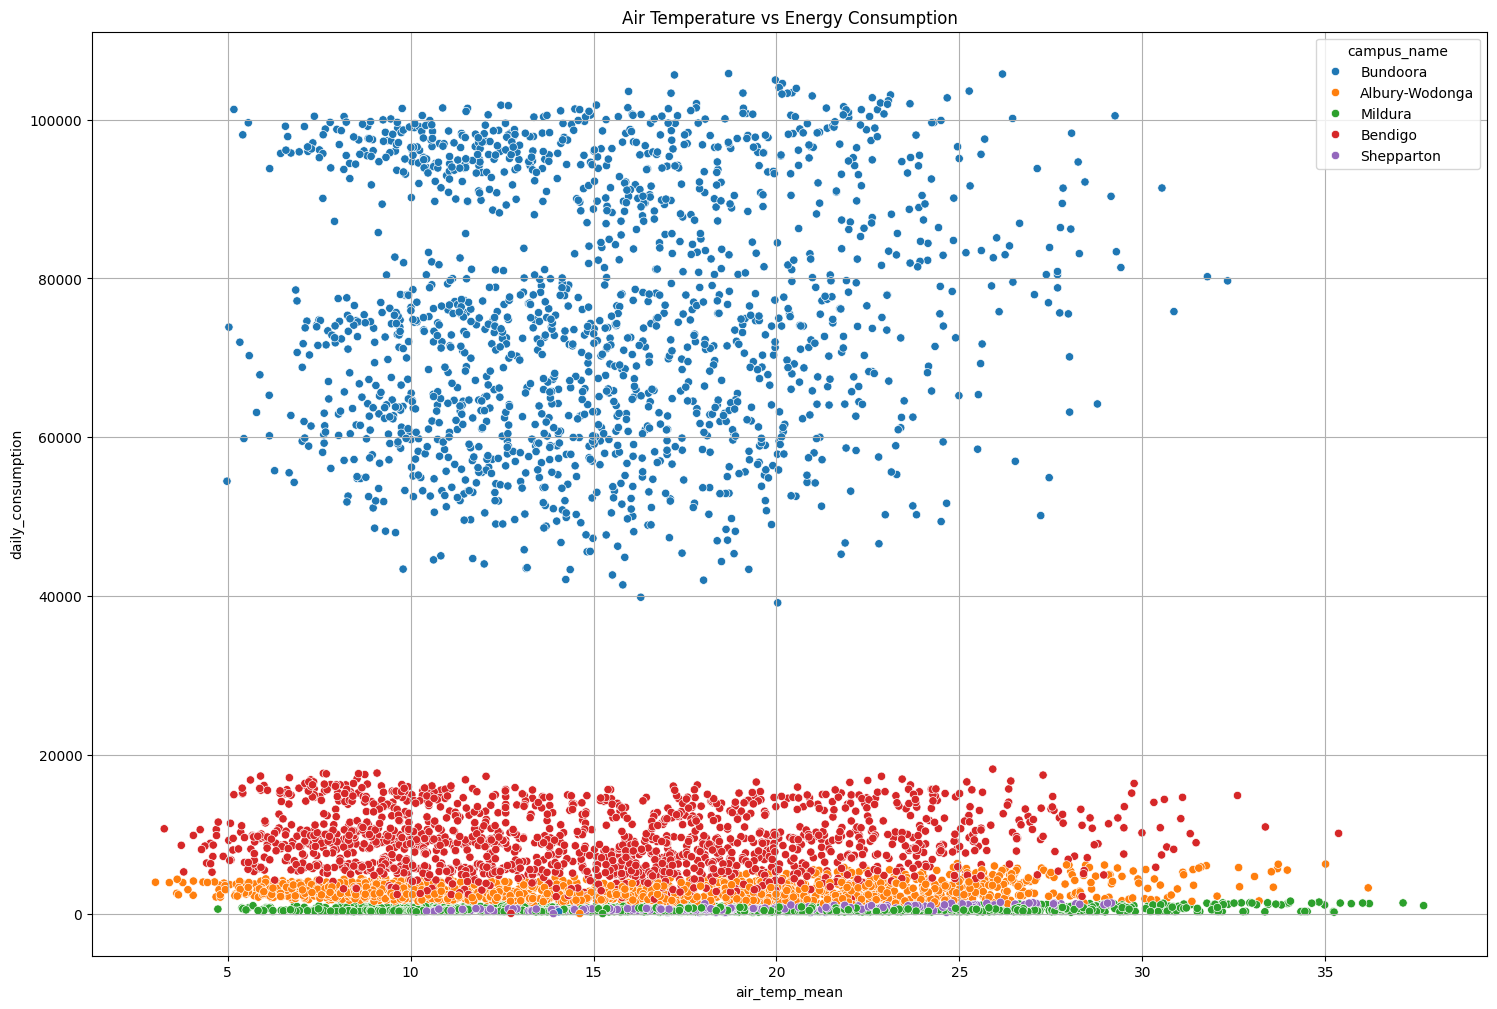

In [37]:
# --- Air temperature vs daily consumption --------------------------------
plt.figure(figsize=(18,12))
sns.scatterplot(x="air_temp_mean", y="daily_consumption", hue="campus_name", data=df)
plt.title("Air Temperature vs Energy Consumption")
plt.show()

## Consumption vs Temperature

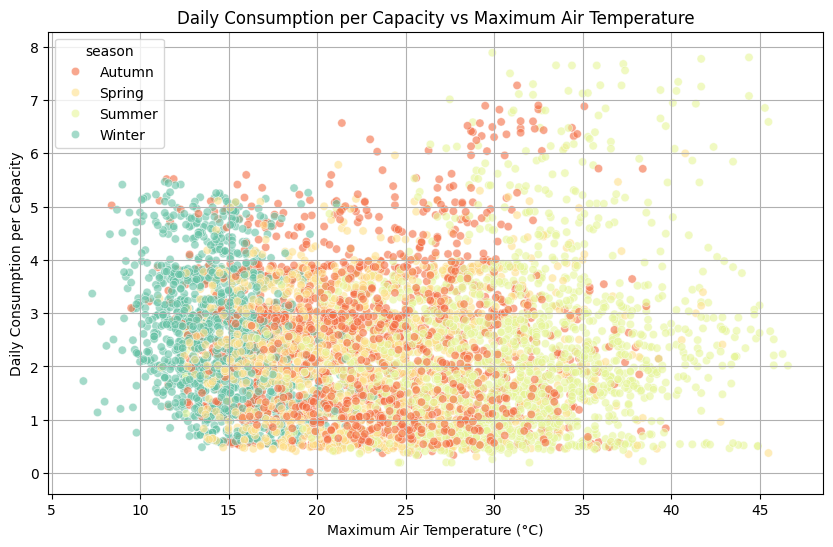

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='air_temp_max', y='consumption_per_capacity', hue='season', alpha=0.6, palette='Spectral')
plt.title("Daily Consumption per Capacity vs Maximum Air Temperature")
plt.xlabel("Maximum Air Temperature (°C)")
plt.ylabel("Daily Consumption per Capacity")
plt.show()

## Heatmap of Consumption vs Temperature and Semester

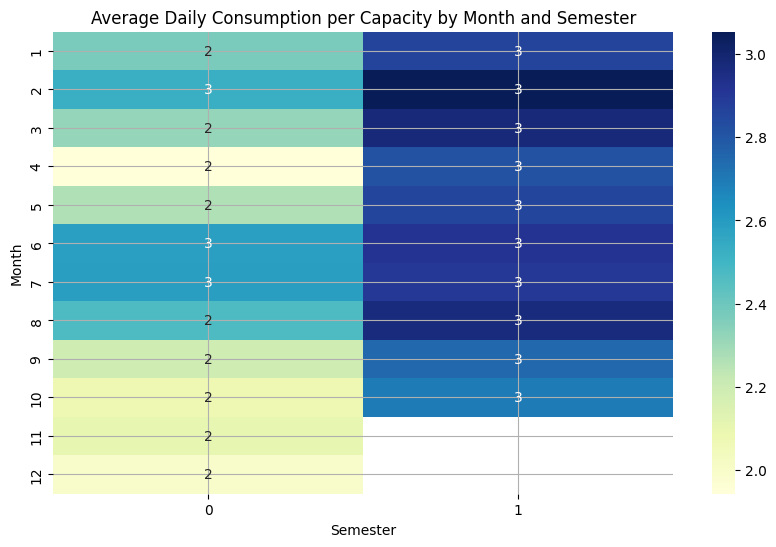

In [39]:
plt.figure(figsize=(10,6))
sns.heatmap(
    df.pivot_table(values='consumption_per_capacity', index='month', columns='is_semester', aggfunc='mean'),
    annot=True, fmt=".0f", cmap="YlGnBu"
)
plt.title("Average Daily Consumption per Capacity by Month and Semester")
plt.xlabel("Semester")
plt.ylabel("Month")
plt.show()

## Campus-wise Average Daily Consumption

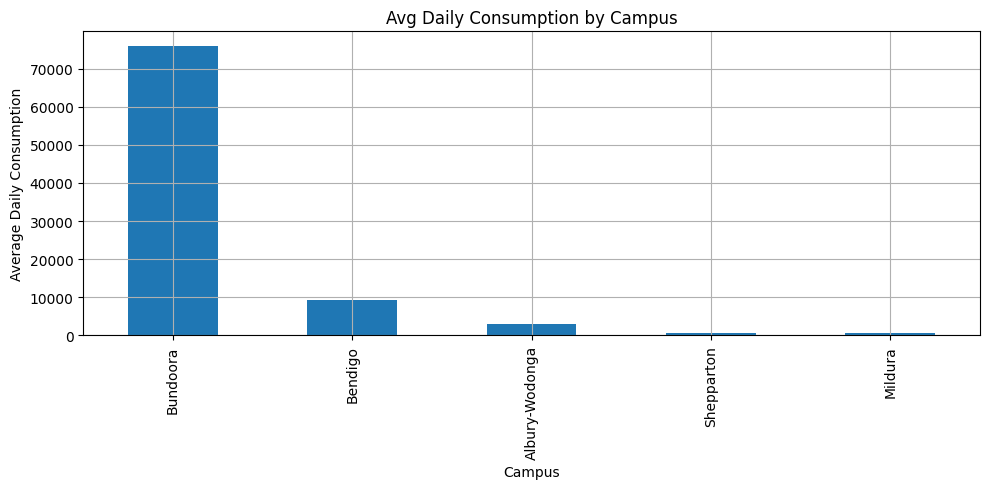

In [40]:
# --- Campus-wise average daily consumption --------------------------------
if 'campus_name' in df.columns:
    means = df.groupby('campus_name')['daily_consumption'].mean().sort_values(ascending=False)
    plt.figure()
    means.plot(kind='bar')
    plt.title('Avg Daily Consumption by Campus')
    plt.xlabel('Campus')
    plt.ylabel('Average Daily Consumption')
    plt.tight_layout()
    plt.show()

## Campus-Wise Temporal Trends of Weather and Degree Day Features

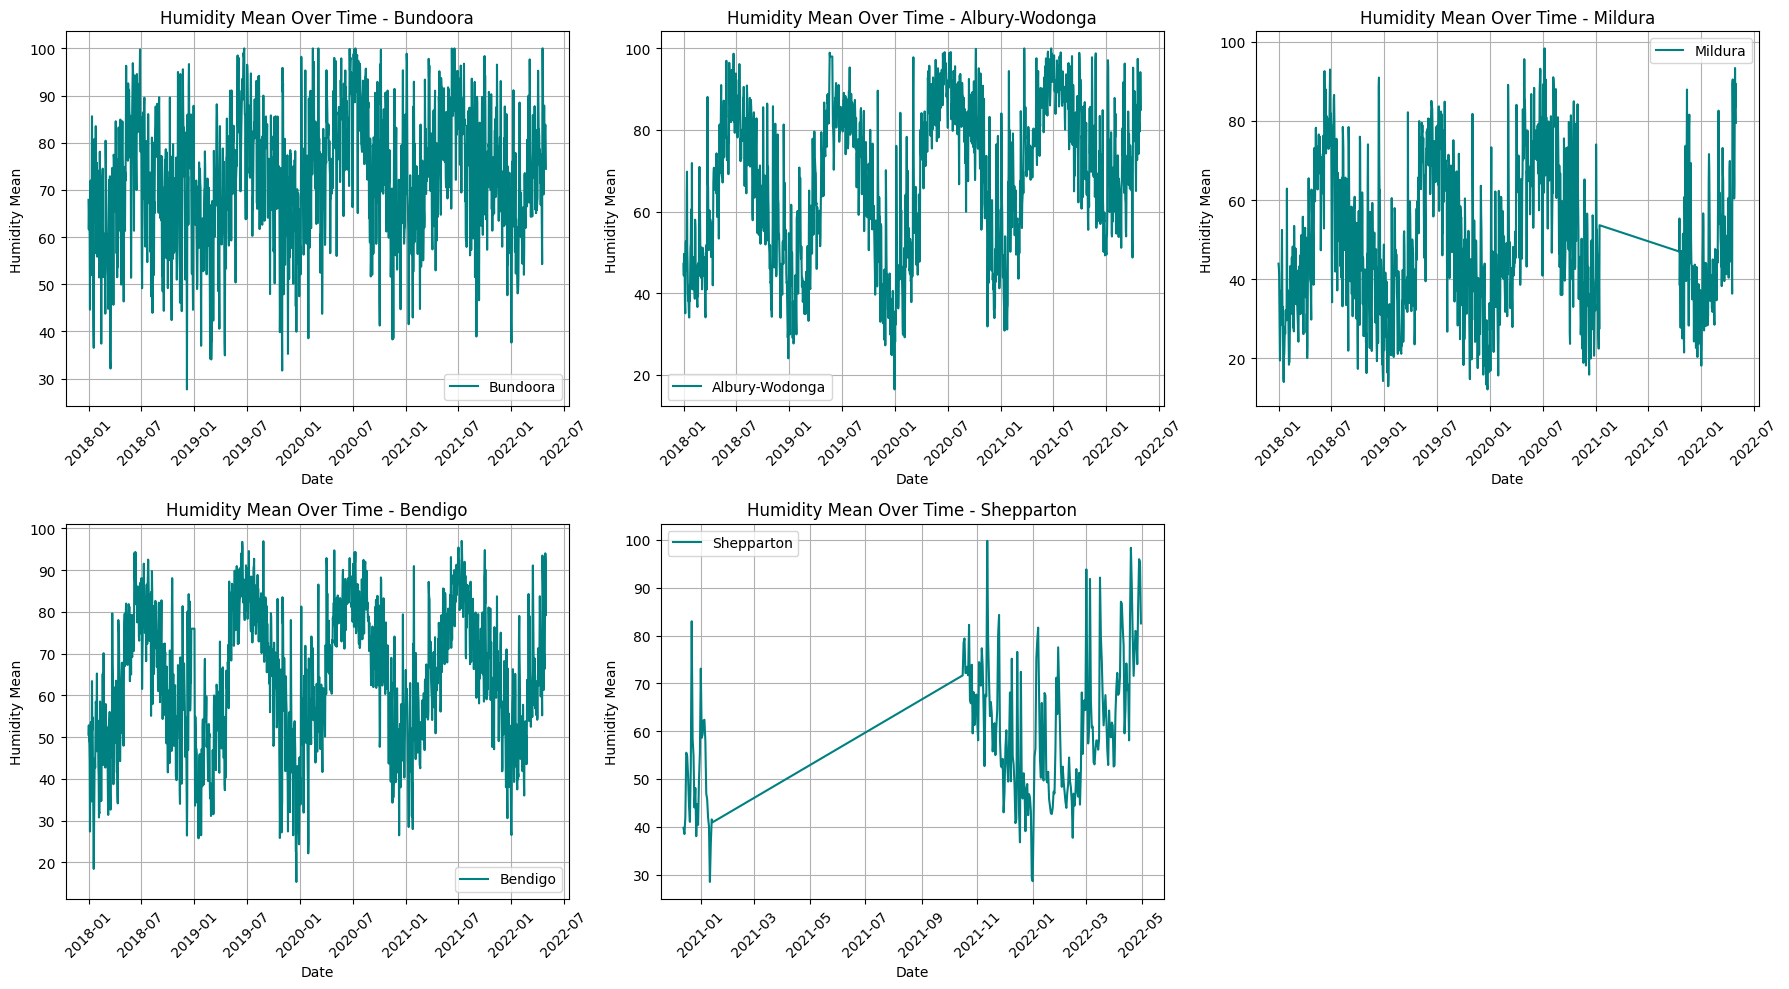

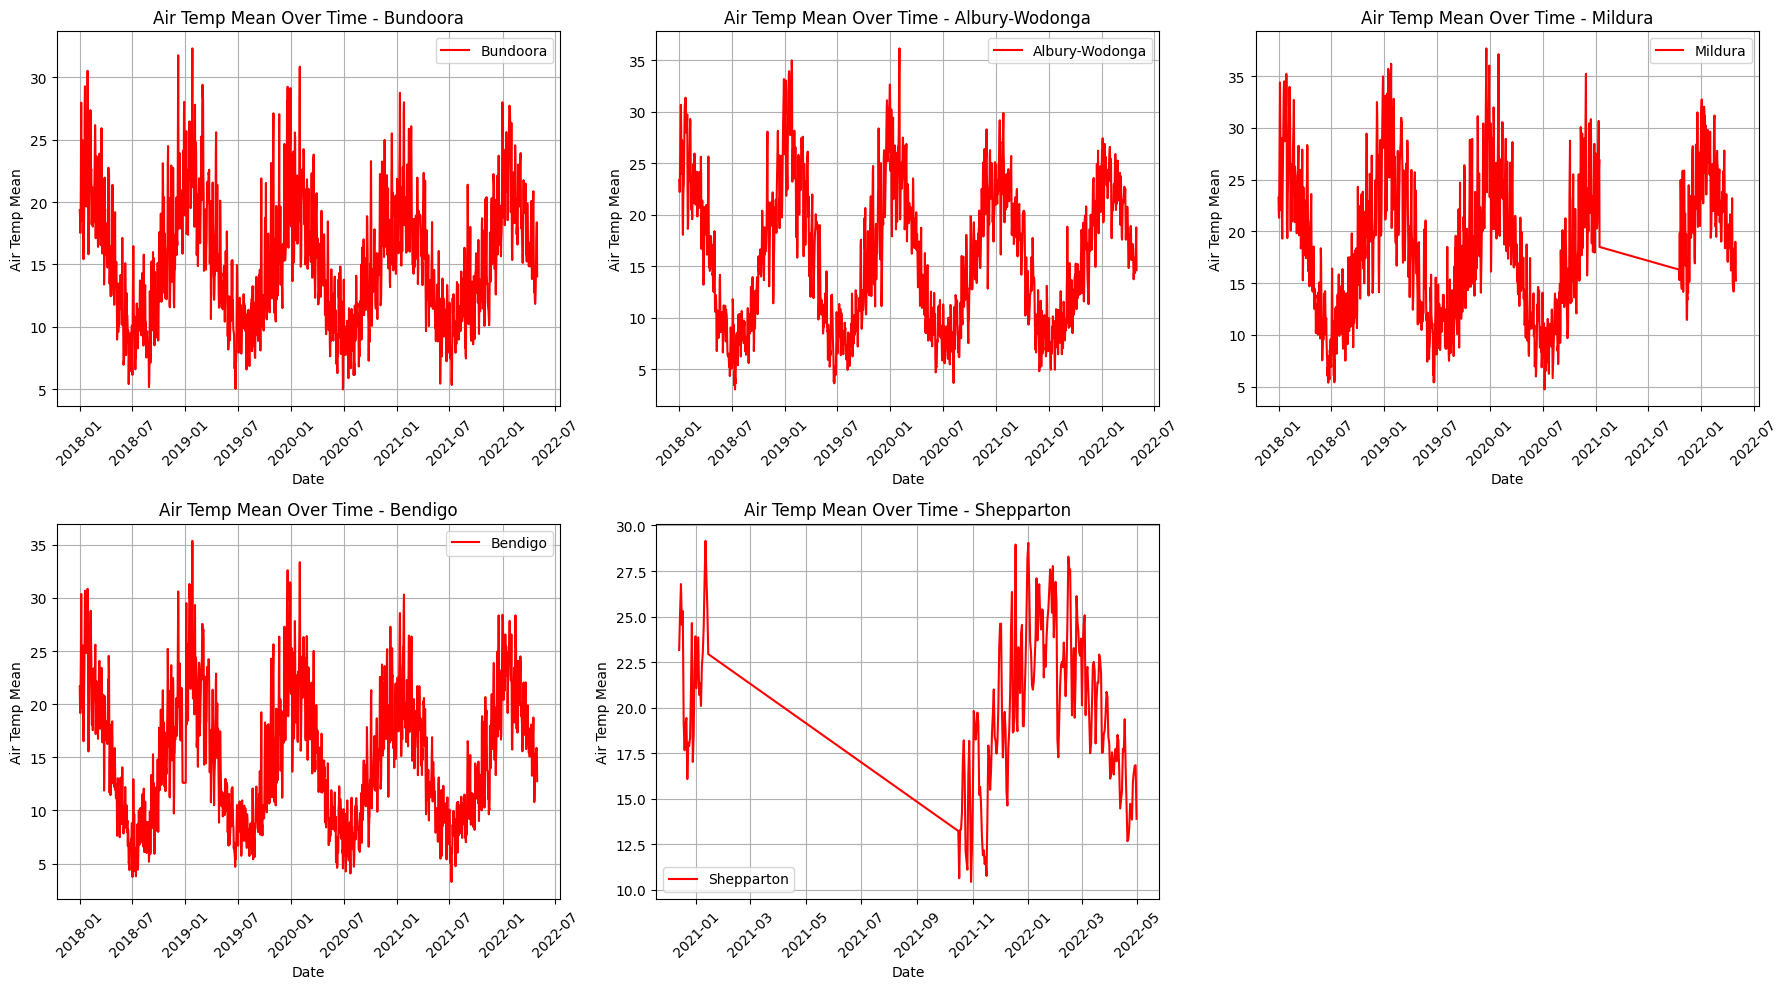

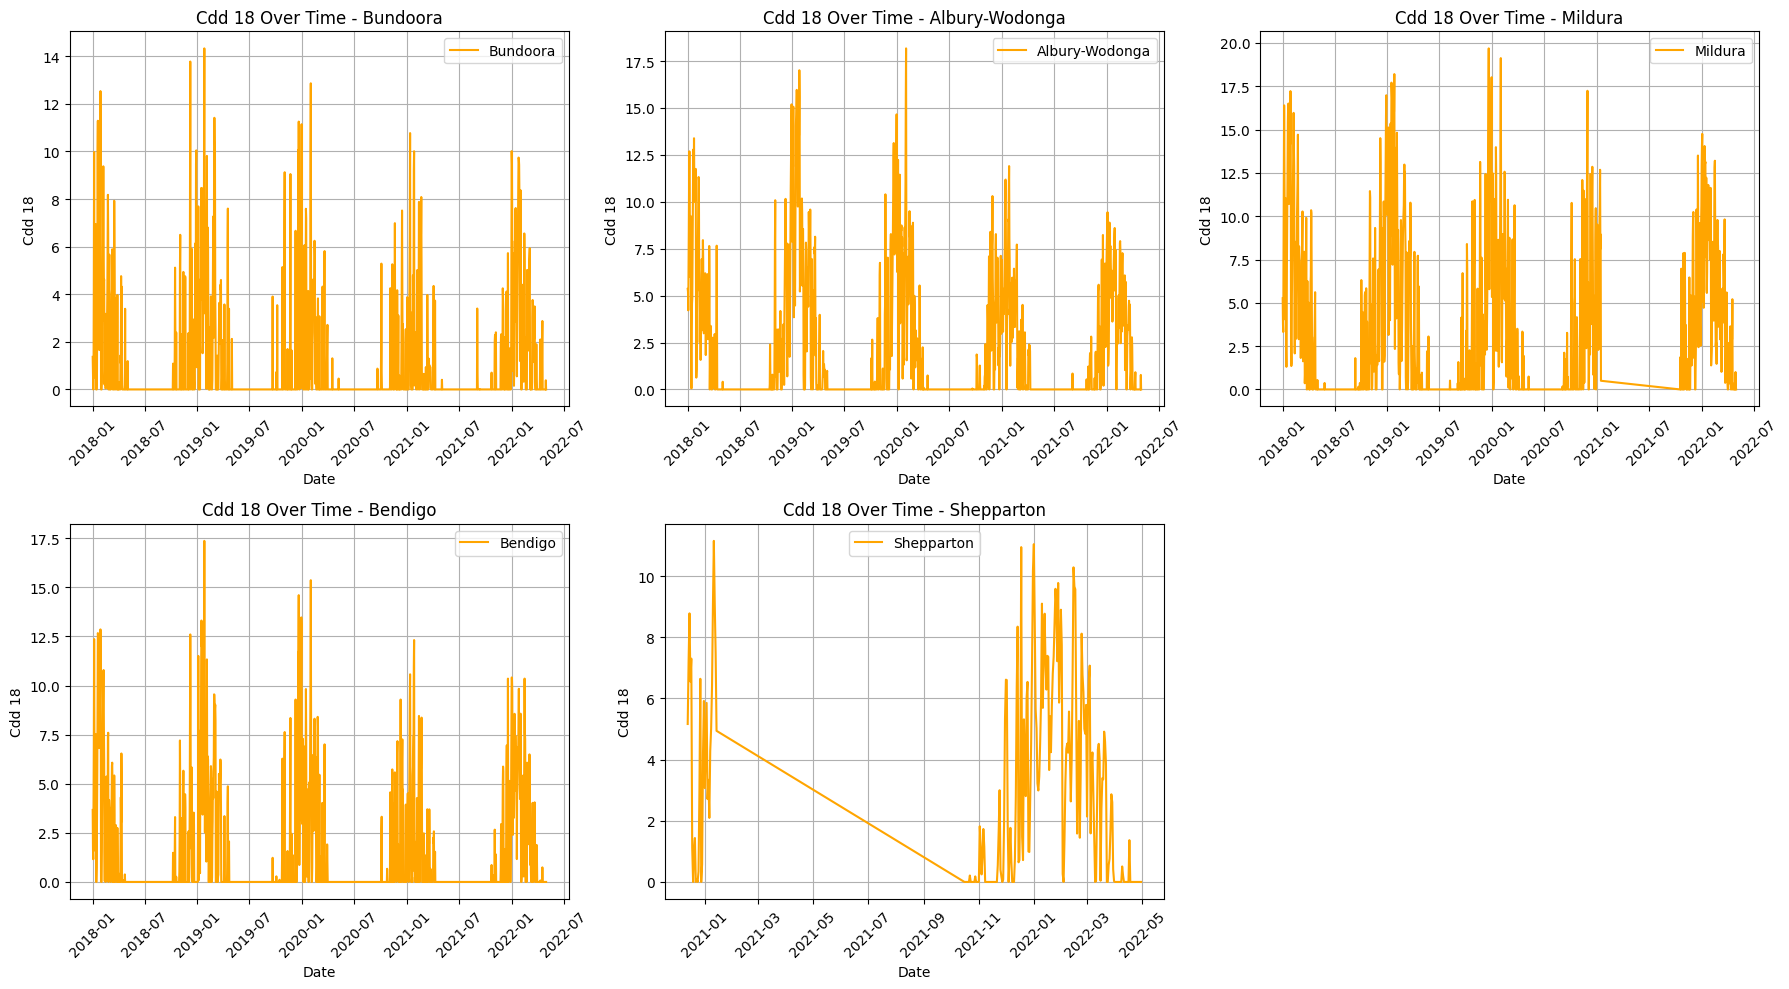

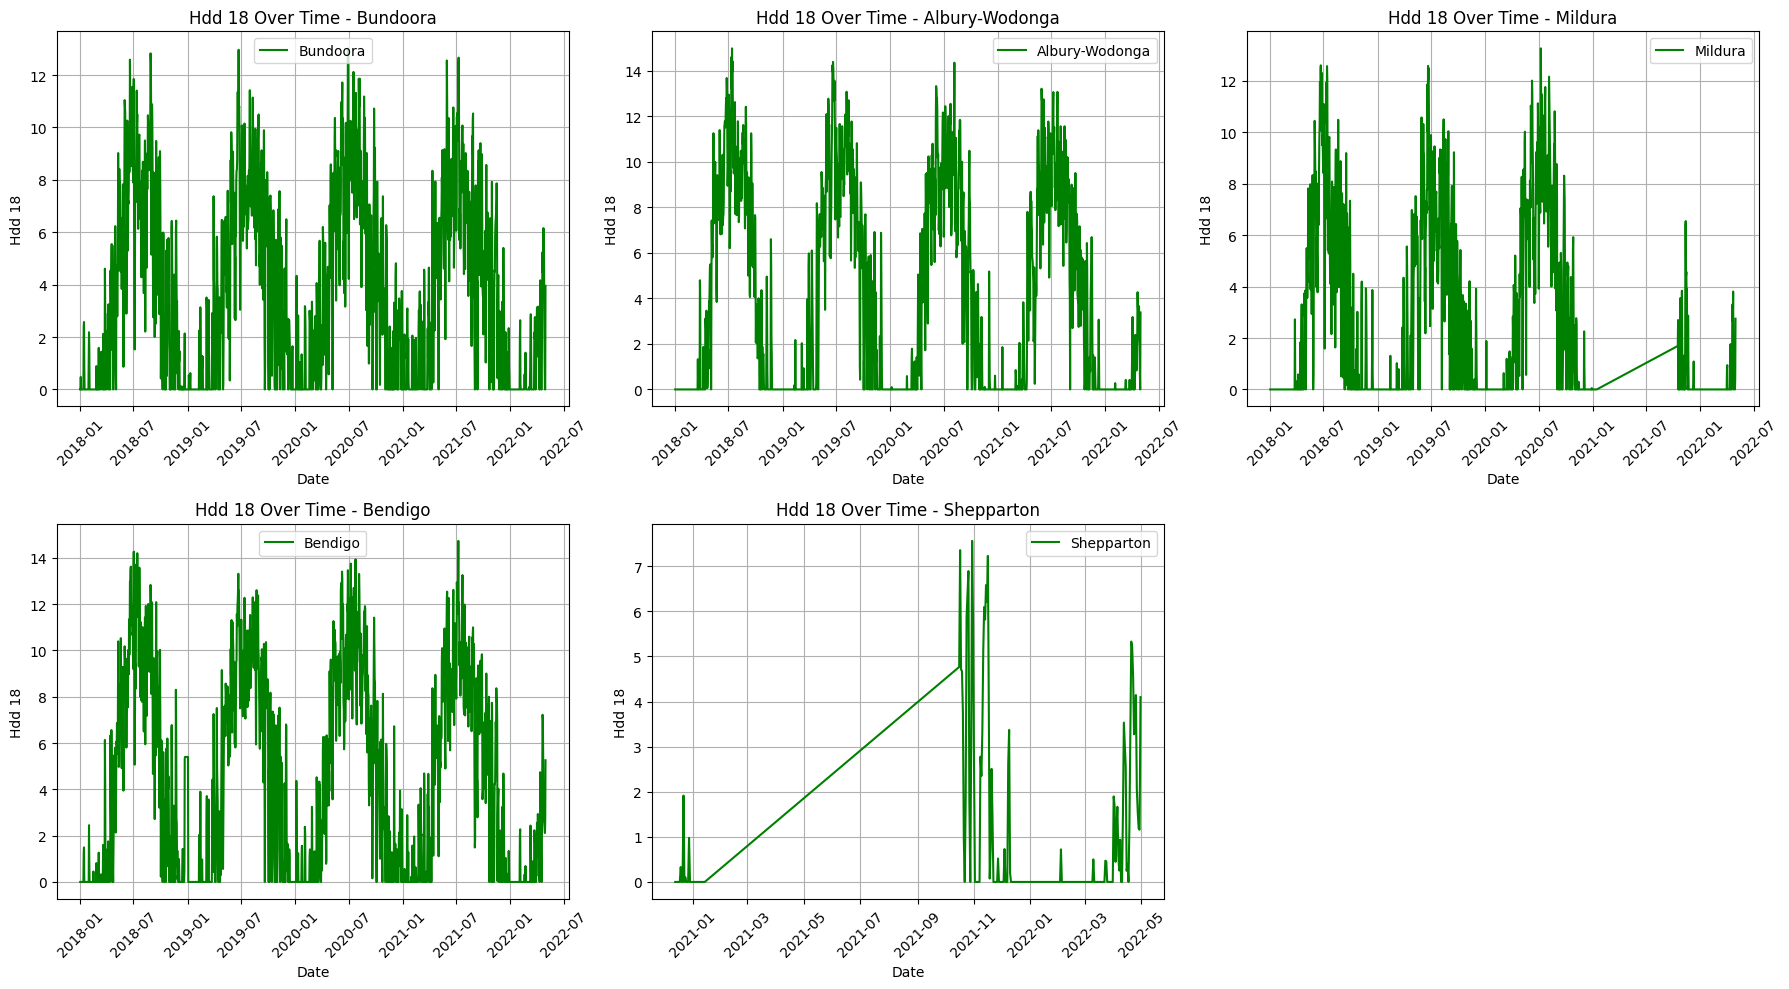

In [41]:
# --- Campus-Wise Temporal Trends of Weather and Degree Day Features ---
features = {
    'humidity_mean': 'teal',
    'air_temp_mean': 'red',
    'cdd_18': 'orange',
    'hdd_18': 'green'
}

for feature, color in features.items():
    campuses = df["campus_name"].unique()
    n_campuses = len(campuses)
    n_cols = 3
    n_rows = (n_campuses + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()

    for i, campus in enumerate(campuses):
        campus_data = df[df["campus_name"] == campus].groupby("date")[feature].mean()
        axes[i].plot(campus_data.index, campus_data.values, label=campus, color=color)
        axes[i].set_title(f"{feature.replace('_',' ').title()} Over Time - {campus}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel(feature.replace('_',' ').title())
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend()

    # Remove empty subplots if necessary
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Outlier Detection in Continuous Features

In [42]:
# --- Outlier Detection Using IQR Method -----------------------------------
def count_outliers_iqr(series):
    """Return number and percentage of outliers in a pandas Series using IQR rule."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), round(100 * len(outliers) / len(series), 2)

# Columns to check
check_cols = ["daily_consumption", "apparent_temp_mean", "air_temp_mean", "air_temp_min",
              "air_temp_max", "humidity_mean", "humidity_max", "humidity_min",
              "dew_point_mean", "cdd_18", "hdd_18"]

outlier_summary = {}
for col in check_cols:
    n_outliers, perc = count_outliers_iqr(df[col].dropna())
    outlier_summary[col] = {"Outlier_Count": n_outliers, "Outlier_%": perc}

outlier_df = pd.DataFrame(outlier_summary).T
print(outlier_df)

                    Outlier_Count  Outlier_%
daily_consumption             0.0       0.00
apparent_temp_mean            0.0       0.00
air_temp_mean                 6.0       0.10
air_temp_min                 13.0       0.21
air_temp_max                  0.0       0.00
humidity_mean                 0.0       0.00
humidity_max                185.0       2.95
humidity_min                 34.0       0.54
dew_point_mean               67.0       1.07
cdd_18                      622.0       9.91
hdd_18                        0.0       0.00




---

As these values represent real-world energy stress events, they were retained to preserve model robustness under extreme scenarios

---



## Outlier Detection and Seasonal Effects on Daily Consumption

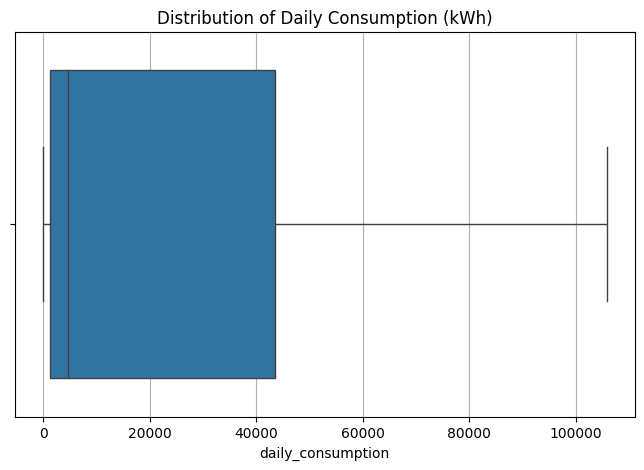

<Figure size 800x500 with 0 Axes>

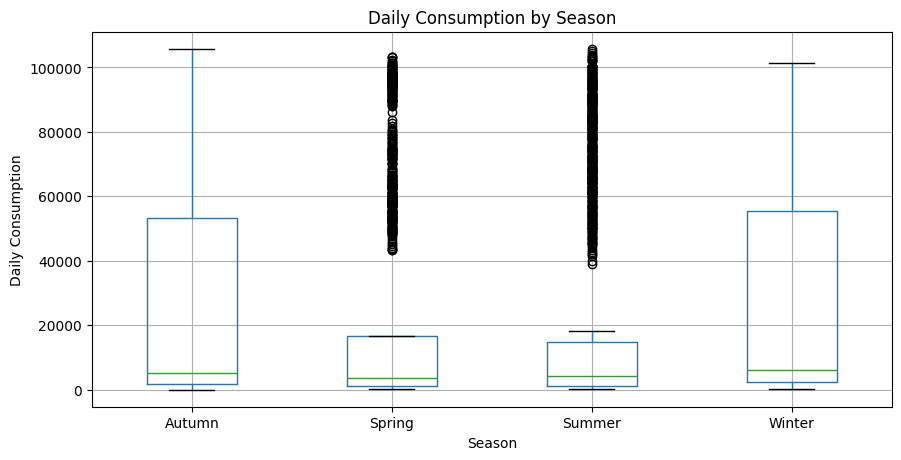

<Figure size 800x500 with 0 Axes>

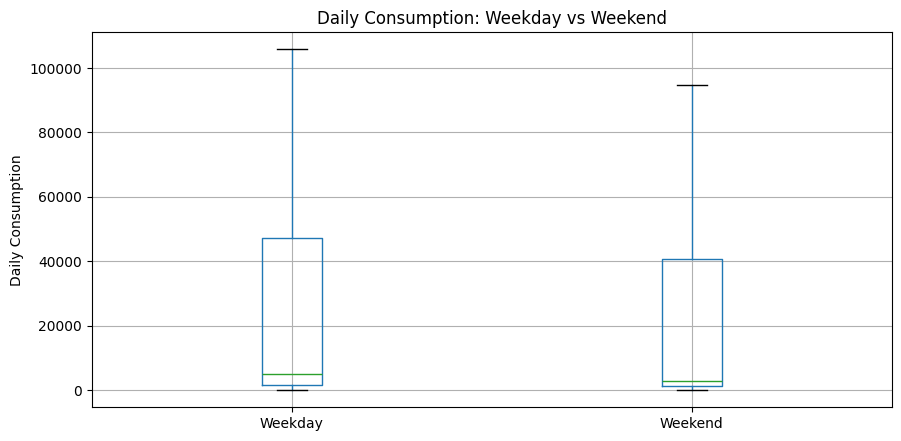

<Figure size 800x500 with 0 Axes>

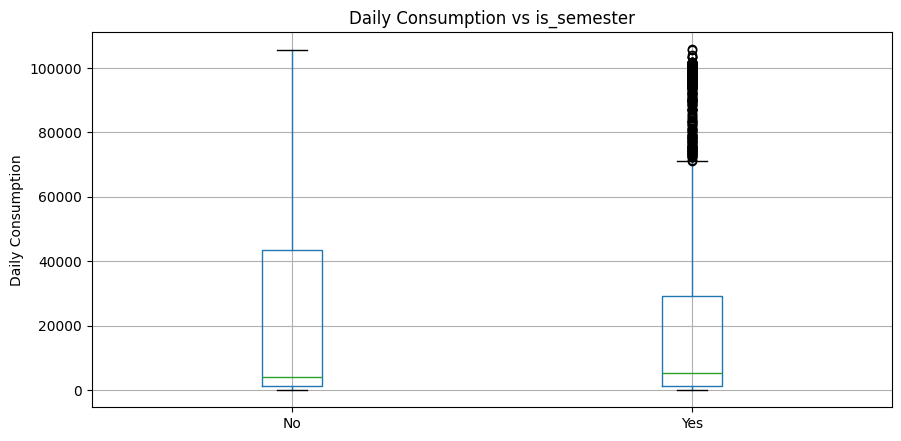

<Figure size 800x500 with 0 Axes>

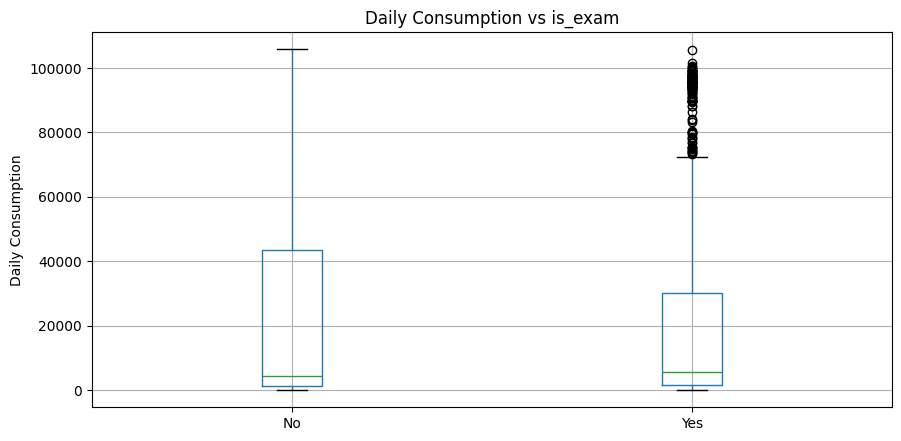

<Figure size 800x500 with 0 Axes>

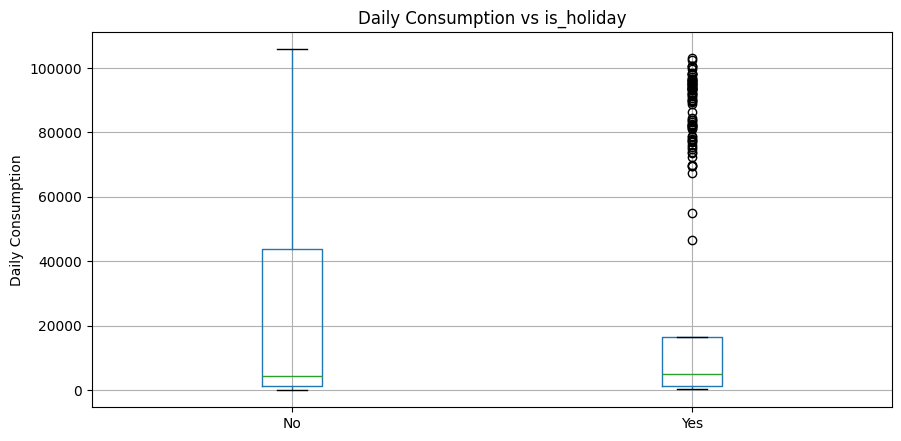

In [43]:
# --- Boxplots for Outlier Detection and Temporal Effects -------------------

# 1. Overall Daily Consumption
plt.figure(figsize=(8,5))
sns.boxplot(x=df["daily_consumption"])
plt.title("Distribution of Daily Consumption (kWh)")
plt.show()

# 2. Daily Consumption by Season
plt.figure(figsize=(8,5))
df.boxplot(column='daily_consumption', by='season')
plt.title('Daily Consumption by Season')
plt.suptitle('')
plt.xlabel('Season'); plt.ylabel('Daily Consumption')
plt.show()

# 3. Weekday vs Weekend Effects
plt.figure(figsize=(8,5))
df.assign(wknd=df['is_weekend'].map({0:'Weekday',1:'Weekend'})) \
  .boxplot(column='daily_consumption', by='wknd')
plt.title('Daily Consumption: Weekday vs Weekend')
plt.suptitle('')
plt.xlabel(''); plt.ylabel('Daily Consumption')
plt.show()

# 4. Academic Event Effects (Semester, Exam, Holiday)
for flag in ['is_semester','is_exam','is_holiday']:
    if flag in df.columns:
        plt.figure(figsize=(8,5))
        df.assign(flag=df[flag].map({0:'No',1:'Yes'})) \
          .boxplot(column='daily_consumption', by='flag')
        plt.title(f'Daily Consumption vs {flag}')
        plt.suptitle('')
        plt.xlabel(''); plt.ylabel('Daily Consumption')
        plt.show()

In [44]:
# Create a working copy of the dataset for further analysis
df_bd = df.copy()

## Hypothesis Testing: Categorical Features vs Daily Consumption

In [45]:
results = []

# Holiday vs Non-holiday
holiday = df_bd[df_bd["is_holiday"] == 1]["daily_consumption"]
non_holiday = df_bd[df_bd["is_holiday"] == 0]["daily_consumption"]
t_stat, p_val = ttest_ind(holiday, non_holiday, equal_var=False)
results.append(["is_holiday", "T-test", p_val, p_val < 0.05])

# Semester vs Non-semester
semester = df_bd[df_bd["is_semester"] == 1]["daily_consumption"]
non_semester = df_bd[df_bd["is_semester"] == 0]["daily_consumption"]
t_stat, p_val = ttest_ind(semester, non_semester, equal_var=False)
results.append(["is_semester", "T-test", p_val, p_val < 0.05])

# Exam vs Non-exam
exam = df_bd[df_bd["is_exam"] == 1]["daily_consumption"]
non_exam = df_bd[df_bd["is_exam"] == 0]["daily_consumption"]
t_stat, p_val = ttest_ind(exam, non_exam, equal_var=False)
results.append(["is_exam", "T-test", p_val, p_val < 0.05])

# Season ANOVA
groups1 = [g["daily_consumption"].values for _, g in df_bd.groupby("season")]
f_stat, p_val = f_oneway(*groups1)
results.append(["season", "ANOVA", p_val, p_val < 0.05])

# Weekend vs Weekday
weekend = df_bd[df_bd["is_weekend"] == 1]["daily_consumption"]
weekday = df_bd[df_bd["is_weekend"] == 0]["daily_consumption"]
t_stat, p_val = ttest_ind(weekend, weekday, equal_var=False)
results.append(["is_weekend", "T-test", p_val, p_val < 0.05])

# Day of week ANOVA
groups2 = [g["daily_consumption"].values for _, g in df_bd.groupby("day_of_week")]
f_stat, p_val = f_oneway(*groups2)
results.append(["day_of_week", "ANOVA", p_val, p_val < 0.05])

# Put results into DataFrame
significance_df = pd.DataFrame(results, columns=["Feature", "Test", "p-value", "Significant (<0.05)"])

print(significance_df)

       Feature    Test       p-value  Significant (<0.05)
0   is_holiday  T-test  1.016604e-01                False
1  is_semester  T-test  4.277283e-05                 True
2      is_exam  T-test  9.707574e-03                 True
3       season   ANOVA  1.841818e-02                 True
4   is_weekend  T-test  1.816287e-09                 True
5  day_of_week   ANOVA  2.660164e-05                 True


/tmp/ipython-input-130579470.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups1 = [g["daily_consumption"].values for _, g in df_bd.groupby("season")]




---

Given the use of tree-based models, all features were retained.

---



# 4. Data Preprocessing: Feature Encoding

## One-Hot Encoding of Categorical Features

In [46]:
# One-Hot Encode 'campus_id' and 'season' for machine learning compatibility
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded = encoder.fit_transform(df_bd[["campus_id", "season"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["campus_id", "season"]))

# Concatenate encoded columns and remove original categorical columns
df_bd = pd.concat([df_bd.drop(columns=["campus_id", "season"]), encoded_df], axis=1)

# Convert encoded columns to integer type
encoding = [
    'campus_id_1','campus_id_2','campus_id_3','campus_id_4','campus_id_5',
    'season_Autumn','season_Spring','season_Summer','season_Winter'
]
for col in encoding:
    df_bd[col] = df_bd[col].astype('int')

## Correlation Analysis of Numeric Features

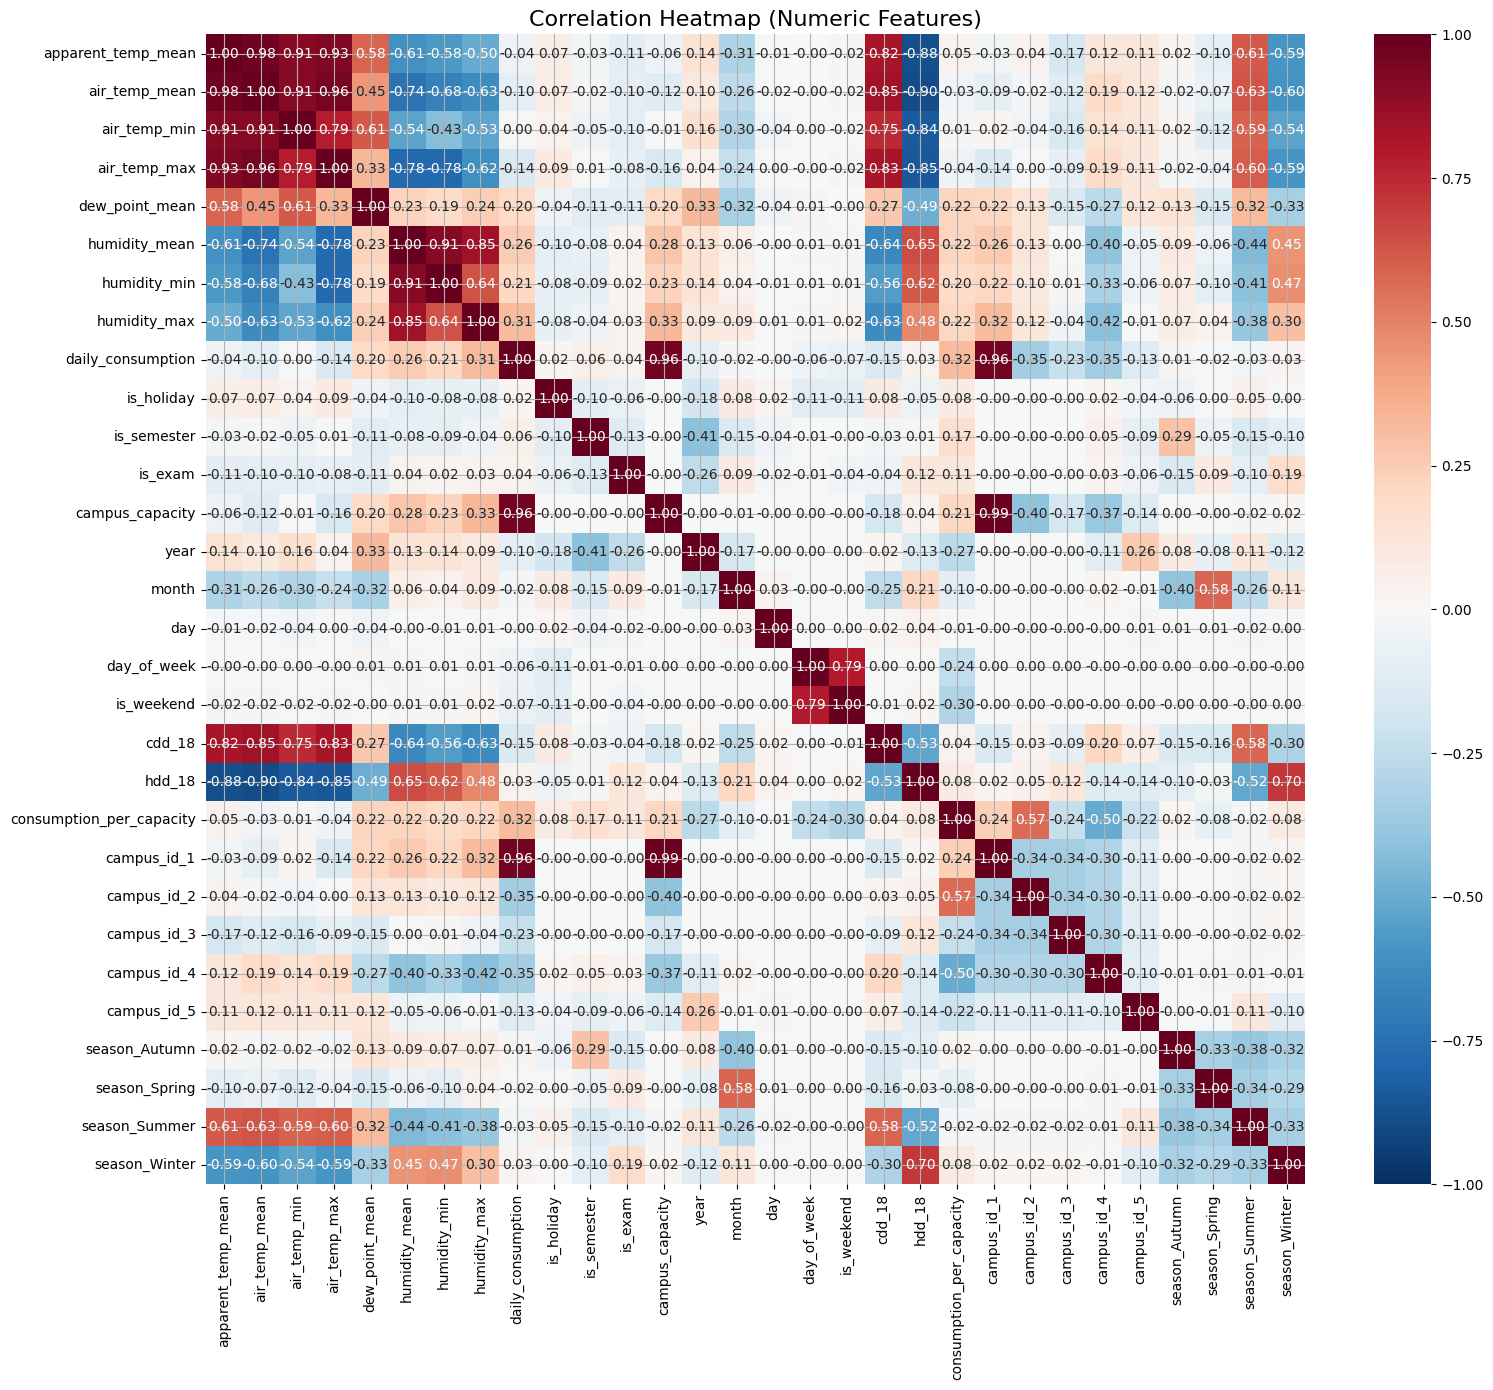

daily_consumption           1.000000
campus_capacity             0.963492
campus_id_1                 0.961065
consumption_per_capacity    0.318371
humidity_max                0.313946
humidity_mean               0.257277
humidity_min                0.209277
dew_point_mean              0.199973
is_semester                 0.058387
is_exam                     0.037575
hdd_18                      0.033442
season_Winter               0.030408
is_holiday                  0.023048
season_Autumn               0.014110
air_temp_min                0.003682
day                        -0.003650
season_Spring              -0.015205
month                      -0.022390
season_Summer              -0.027653
apparent_temp_mean         -0.040258
day_of_week                -0.056021
is_weekend                 -0.069950
year                       -0.097089
air_temp_mean              -0.099370
campus_id_5                -0.130568
Name: daily_consumption, dtype: float64

In [47]:
# Compute correlation among numeric features
numeric_cols = df_bd.select_dtypes(include=[np.number]).columns.tolist()
corr = df_bd[numeric_cols].corr()

# Plot correlation heatmap with Seaborn
plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    annot=True,       # display correlation values
    fmt=".2f",        # numeric formatting
    cmap="RdBu_r",    # red-blue color scale for positive/negative correlations
    vmin=-1, vmax=1,  # fix color scale range
    linewidths=0      # remove cell separation lines
)
plt.title('Correlation Heatmap (Numeric Features)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print correlations with target variable
target_corr = corr['daily_consumption'].sort_values(ascending=False)
target_corr.head(25)



---

Although these correlations highlight varying degrees of association with energy consumption, I decided to keep all variables. Since the modeling approach relies on tree-based algorithms, which are less sensitive to multicollinearity and can automatically identify relevant splits, retaining all features ensures that no potentially useful signal is excluded.

---



In [48]:
# Inspect dataset structure, data types, and non-null counts
print(df_bd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      6277 non-null   datetime64[ns]
 1   apparent_temp_mean        6277 non-null   float64       
 2   air_temp_mean             6277 non-null   float64       
 3   air_temp_min              6277 non-null   float64       
 4   air_temp_max              6277 non-null   float64       
 5   dew_point_mean            6277 non-null   float64       
 6   humidity_mean             6277 non-null   float64       
 7   humidity_min              6277 non-null   float64       
 8   humidity_max              6277 non-null   float64       
 9   daily_consumption         6277 non-null   float64       
 10  is_holiday                6277 non-null   int64         
 11  is_semester               6277 non-null   int64         
 12  is_exam             

# 5. Predictive Modeling and Optimization of Campus Energy Consumption

## Path 1 (All campuses together)

In [49]:
# Display the first 5 rows of the processed dataset
print(df_bd.head())

        date  apparent_temp_mean  air_temp_mean  air_temp_min  air_temp_max  \
0 2018-01-01           18.536667      19.368125          14.7          27.3   
1 2018-01-01           22.091806      23.359722          13.4          32.3   
2 2018-01-01           20.302778      23.262708          14.3          31.6   
3 2018-01-01           18.945625      21.664375          12.0          30.7   
4 2018-01-02           17.655486      21.756250          15.2          28.7   

   dew_point_mean  humidity_mean  humidity_min  humidity_max  \
0       12.392014      67.898611          33.0          99.0   
1        9.649028      47.235417          19.0          84.0   
2        8.689861      43.923611          17.0          77.0   
3        8.984028      50.615972          18.0          91.0   
4        7.488889      43.036806          21.0          72.0   

   daily_consumption  is_holiday  is_semester  is_exam     campus_name  \
0          69504.087           1            0        0        Bund

### Feature and Target Separation

In [50]:
# Define feature matrix X and target vector y for modeling
X_all = df_bd.drop(columns=["date", "year", "campus_name", "daily_consumption", "consumption_per_capacity"])
y_all = df_bd["consumption_per_capacity"]

In [51]:
# Inspect feature matrix structure
print('X_All Information \n')
X_all.info()

# Inspect target vector structure
print('\n y_All Information \n')
y_all.info()

X_All Information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   apparent_temp_mean  6277 non-null   float64
 1   air_temp_mean       6277 non-null   float64
 2   air_temp_min        6277 non-null   float64
 3   air_temp_max        6277 non-null   float64
 4   dew_point_mean      6277 non-null   float64
 5   humidity_mean       6277 non-null   float64
 6   humidity_min        6277 non-null   float64
 7   humidity_max        6277 non-null   float64
 8   is_holiday          6277 non-null   int64  
 9   is_semester         6277 non-null   int64  
 10  is_exam             6277 non-null   int64  
 11  campus_capacity     6277 non-null   int64  
 12  month               6277 non-null   int64  
 13  day                 6277 non-null   int32  
 14  day_of_week         6277 non-null   int64  
 15  is_weekend          6277 non-null  

### Train-Test Split

In [52]:
# Split features and target into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# Display dataset sizes for verification
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (5021, 27)  Test size: (1256, 27)


### Baseline Machine Learning Models

In [53]:
# ----------------------------
# Baseline Tree-Based Models
# ----------------------------

# Random Forest (baseline)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Gradient Boosting (baseline)
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# XGBoost (baseline)
xgbr = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)

# Performance Metrics
print("\n--- Baseline Random Forest ---")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MSE :", mean_squared_error(y_test, y_pred))
print("R²  :", r2_score(y_test, y_pred))

print("\n--- Baseline Gradient Boosting ---")
print("MAE :", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("MSE :", mean_squared_error(y_test, y_pred_gb))
print("R²  :", r2_score(y_test, y_pred_gb))

print("\n--- Baseline XGBoost ---")
print("MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MSE :", mean_squared_error(y_test, y_pred_xgb))
print("R²  :", r2_score(y_test, y_pred_xgb))


--- Baseline Random Forest ---
MAE : 0.36168336629268744
RMSE: 0.4993690573970572
MSE : 0.24936945548562545
R²  : 0.855831921553504

--- Baseline Gradient Boosting ---
MAE : 0.38891333437934655
RMSE: 0.5168824158262986
MSE : 0.2671674317904307
R²  : 0.8455423692941738

--- Baseline XGBoost ---
MAE : 0.36302450969370054
RMSE: 0.4882103417881588
MSE : 0.23834933782891082
R²  : 0.8622029872629305




---

The baseline model evaluation shows that XGBoost achieves the best performance among the three models, with the highest R² score (0.8622) and the lowest RMSE (0.4882) and MAE (0.3630). This indicates that XGBoost is the most promising candidate for further hyperparameter tuning.

---



### Hyperparameter Tuning for XGBoost

In [54]:
# ----------------------------
# XGBoost Hyperparameter Tuning
# ----------------------------

# Initialize XGBoost Regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Hyperparameter grid
param_dist = {
    "n_estimators": [200, 300, 400, 500, 600],
    "max_depth": [3, 4, 5, 6, 7, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "reg_alpha": [0, 0.01, 0.1, 0.5, 1],
    "reg_lambda": [1, 1.5, 2, 3]
}

# Randomized search with 3-fold CV
random_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# Best hyperparameters and cross-validation score
print("\n--- Best Hyperparameters for XGBoost ---")
print(random_search.best_params_)
print("Best CV R² Score:", random_search.best_score_)

# Evaluate tuned model on test set
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\n--- Tuned XGBoost Performance ---")
print("MAE :", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("MSE :", mean_squared_error(y_test, y_pred_best))
print("R²  :", r2_score(y_test, y_pred_best))

Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- Best Hyperparameters for XGBoost ---
{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best CV R² Score: 0.8456026318771422

--- Tuned XGBoost Performance ---
MAE : 0.3558914636505285
RMSE: 0.4822150197563398
MSE : 0.23253132527860715
R²  : 0.8655665575451106




---

✅ Interpretation:

* subsample = 0.9 → Each tree uses 90% of the training data, which helps in reducing overfitting by introducing randomness.
* reg_lambda = 1.5 & reg_alpha=0.5 → These are L2 and L1 regularization terms, respectively, which penalize complex models and prevent overfitting.
* n_estimators = 400 → The number of boosting rounds (trees) in the ensemble. A higher number generally leads to better performance but can also increase the risk of overfitting if not properly regularized.
* max_depth = 6 → The maximum depth of each tree. This parameter controls the complexity of the model; deeper trees can capture more complex relationships but are more prone to overfitting.
* learning_rate = 0.05 → The step size shrinkage used in each boosting step. A smaller learning rate requires more estimators but can lead to a more robust model.
* gamma = 0.1 → Minimum loss reduction required to make a further partition on a leaf node of the tree. A higher gamma makes the algorithm more conservative.
* colsample_bytree  =0.7 → Each tree uses 70% of the features when building its splits. This helps in preventing overfitting by reducing feature correlation.
* CV R² Score = 0.9447 → Excellent, very close to test R².

---



### Feature Importance Analysis (Tuned XGBoost)


--- Top 15 Important Features (XGBoost) ---
campus_id_2        0.206234
campus_id_4        0.206142
campus_id_1        0.148044
campus_capacity    0.139962
campus_id_3        0.053964
campus_id_5        0.051220
is_weekend         0.034868
day_of_week        0.029817
is_semester        0.027315
is_exam            0.018558
season_Winter      0.014228
is_holiday         0.008152
month              0.008014
humidity_max       0.005549
air_temp_max       0.005533
dtype: float32


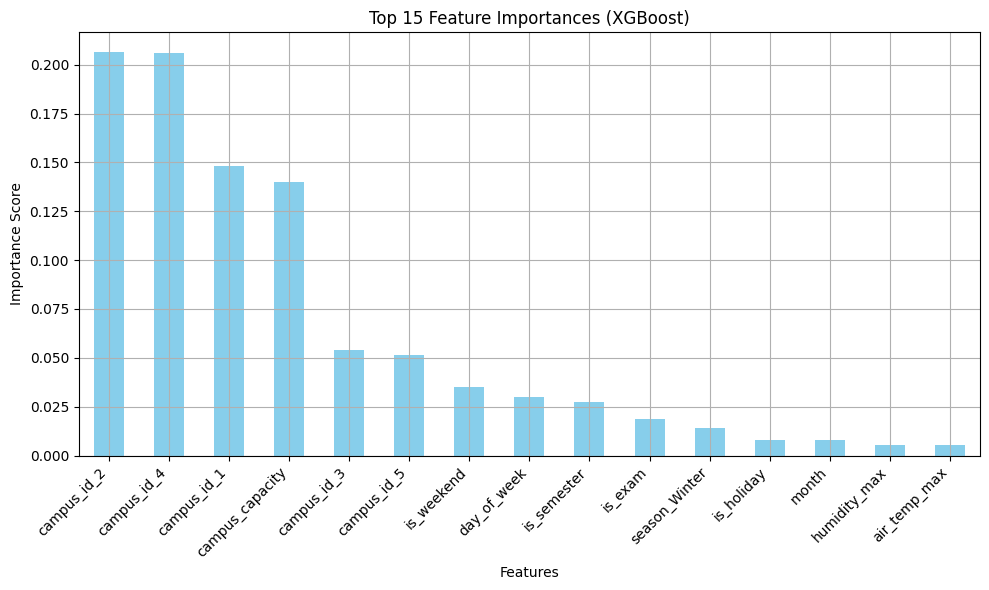

In [55]:
# ----------------------------
# Feature Importance for Tuned XGBoost
# ----------------------------

# Extract feature importances
importances = best_xgb.feature_importances_
feat_imp = pd.Series(importances, index=X_all.columns).sort_values(ascending=False)

# Display top 15 features
print("\n--- Top 15 Important Features (XGBoost) ---")
print(feat_imp.head(15))

# Plot top 15 feature importances
plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind="bar", color='skyblue')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



---

Feature importance analysis shows that campus identity and capacity are the strongest predictors of energy use, followed by calendar factors (weekends, semesters, exams). Weather variables play a smaller but supportive role. This indicates that structural and scheduling factors drive consumption more than weather conditions.

---



## Path 2 (Separate models per campus)

### One-Hot Encoding of Seasonal Features for Per-Campus Models

In [56]:
df_2 = df.copy()

# One-Hot Encode 'season' for campus-specific models
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded = encoder.fit_transform(df_2[["season"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["season"]))

# Concatenate encoded columns and remove original 'season'
df_2 = pd.concat([df_2.drop(columns=["season"]), encoded_df], axis=1)

# Convert season and campus_id columns to integer type
encoding = ['season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'campus_id']
for col in encoding:
    df_2[col] = df_2[col].astype('int')

In [57]:
# df_2 contains one-hot encoded 'season' columns and 'campus_id' for separate campus models
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   campus_id                 6277 non-null   int64         
 1   date                      6277 non-null   datetime64[ns]
 2   apparent_temp_mean        6277 non-null   float64       
 3   air_temp_mean             6277 non-null   float64       
 4   air_temp_min              6277 non-null   float64       
 5   air_temp_max              6277 non-null   float64       
 6   dew_point_mean            6277 non-null   float64       
 7   humidity_mean             6277 non-null   float64       
 8   humidity_min              6277 non-null   float64       
 9   humidity_max              6277 non-null   float64       
 10  daily_consumption         6277 non-null   float64       
 11  is_holiday                6277 non-null   int64         
 12  is_semester         

### Model Selection, Hyperparameter Tuning, and Feature Importance


==================== Campus 1 ====================
Selected best model: RandomForest
Tuned R²: 0.5235, RMSE: 11513.28

Top 10 Features:
is_semester           0.194817
is_exam               0.092538
day_of_week           0.092305
dew_point_mean        0.078270
is_weekend            0.078131
month                 0.060113
air_temp_min          0.055060
humidity_mean         0.054533
day                   0.050994
apparent_temp_mean    0.049680
dtype: float64


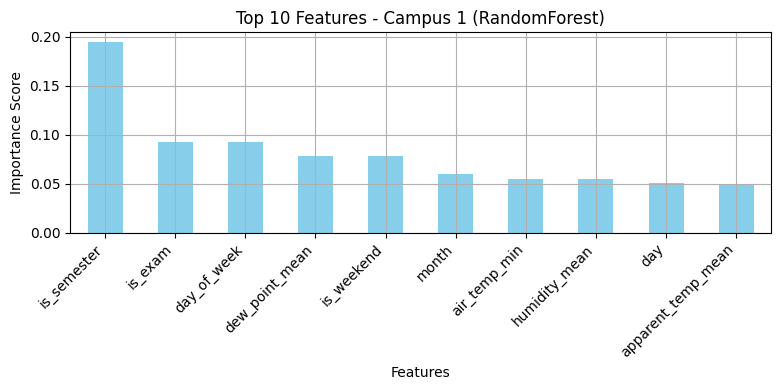


==================== Campus 2 ====================
Selected best model: RandomForest
Tuned R²: 0.6976, RMSE: 582.44

Top 10 Features:
day_of_week       0.206062
is_weekend        0.117924
air_temp_max      0.102242
air_temp_min      0.087627
is_semester       0.085139
month             0.080830
dew_point_mean    0.042676
humidity_min      0.039738
humidity_mean     0.037237
day               0.034185
dtype: float64


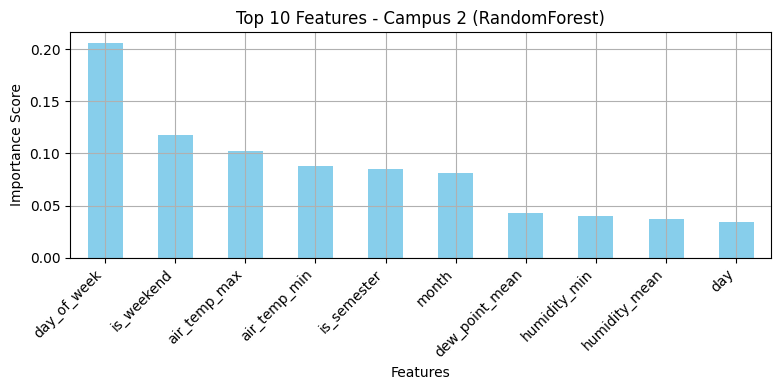


==================== Campus 4 ====================
Selected best model: RandomForest
Tuned R²: 0.6342, RMSE: 161.89

Top 10 Features:
day_of_week       0.274187
is_weekend        0.100122
air_temp_mean     0.087130
cdd_18            0.079991
air_temp_max      0.067793
is_semester       0.065598
air_temp_min      0.051849
dew_point_mean    0.042246
is_exam           0.035192
season_Winter     0.035116
dtype: float64


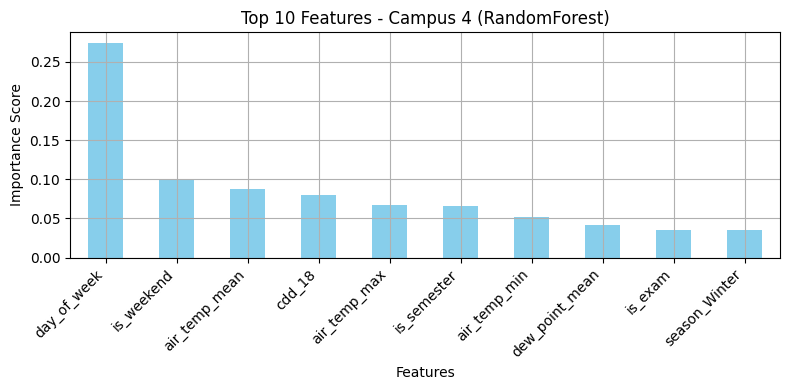


==================== Campus 3 ====================
Selected best model: GradientBoosting
Tuned R²: 0.4807, RMSE: 2625.81

Top 10 Features:
day_of_week       0.141365
is_weekend        0.130098
month             0.096301
air_temp_max      0.085753
is_semester       0.082843
humidity_min      0.052689
dew_point_mean    0.050694
is_exam           0.049840
air_temp_min      0.048649
humidity_mean     0.044395
dtype: float64


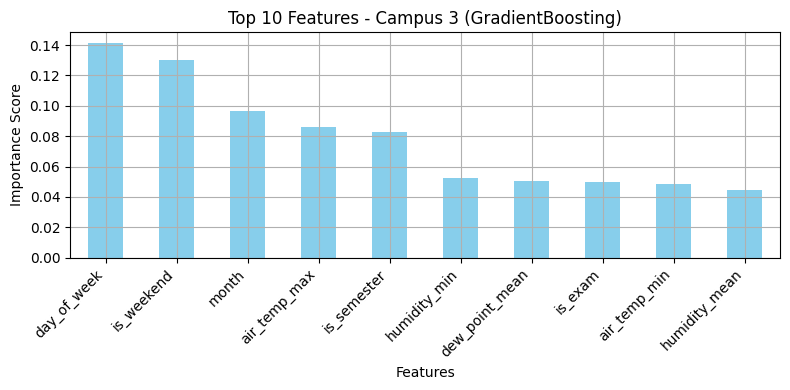


==================== Campus 5 ====================
Selected best model: GradientBoosting
Tuned R²: 0.5978, RMSE: 183.73

Top 10 Features:
apparent_temp_mean    0.519306
air_temp_mean         0.066755
day                   0.057175
month                 0.054386
air_temp_max          0.052092
air_temp_min          0.045787
day_of_week           0.041294
cdd_18                0.038052
dew_point_mean        0.033409
humidity_mean         0.029312
dtype: float64


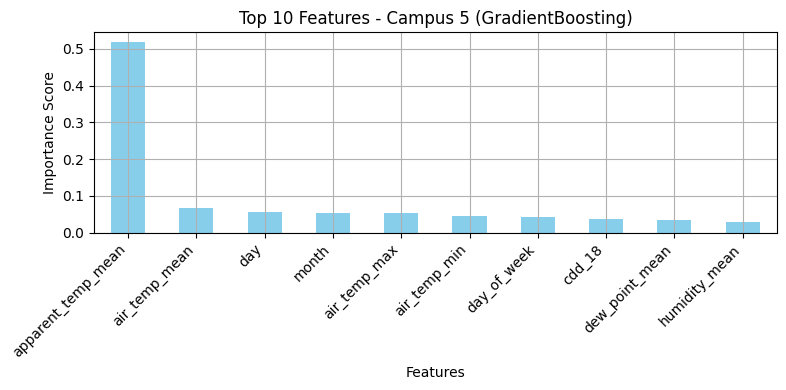

In [58]:
results = []

for campus in df_2["campus_id"].unique():
    print(f"\n==================== Campus {campus} ====================")

    # 1. Subset campus data
    df_campus = df_2[df_2["campus_id"] == campus].copy()
    X = df_campus.drop(columns=["date", "year", "campus_name", "daily_consumption", "consumption_per_capacity"])
    y = df_campus["daily_consumption"]

    # 2. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Baseline models
    models = {
        "RandomForest": RandomForestRegressor(random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1)
    }
    baseline_results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        baseline_results[name] = {
            "R2": r2_score(y_test, preds),
            "MAE": mean_absolute_error(y_test, preds),
            "MSE": mean_squared_error(y_test, preds),
            "RMSE": np.sqrt(mean_squared_error(y_test, preds))
        }

    # 4. Select best model (highest R²)
    best_model_name = max(baseline_results, key=lambda x: baseline_results[x]["R2"])
    print(f"Selected best model: {best_model_name}")

    # 5. Hyperparameter tuning for best model
    # (Set parameter grid per model)
    if best_model_name == "RandomForest":
        param_dist = {"n_estimators": [100,200,300,500], "max_depth":[None,5,10,15],
                      "min_samples_split":[2,5,10], "min_samples_leaf":[1,2,4]}
        model = RandomForestRegressor(random_state=42)
    elif best_model_name == "GradientBoosting":
        param_dist = {"n_estimators":[100,200,300,400], "learning_rate":[0.01,0.05,0.1,0.2],
                      "max_depth":[3,4,5], "subsample":[0.7,0.8,1.0]}
        model = GradientBoostingRegressor(random_state=42)
    else: # XGBoost
        param_dist = {"n_estimators":[200,300,400,500], "max_depth":[3,4,5,6,7],
                      "learning_rate":[0.01,0.05,0.1,0.2], "subsample":[0.7,0.8,0.9,1.0],
                      "colsample_bytree":[0.7,0.8,0.9,1.0]}
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                       n_iter=20, scoring="r2", cv=3, n_jobs=-1, random_state=42, verbose=0)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    preds_best = best_model.predict(X_test)

    # 6. Record tuned performance
    tuned_results = {
        "Model": best_model_name,
        "R2": r2_score(y_test, preds_best),
        "MAE": mean_absolute_error(y_test, preds_best),
        "MSE": mean_squared_error(y_test, preds_best),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds_best))
    }
    print(f"Tuned R²: {tuned_results['R2']:.4f}, RMSE: {tuned_results['RMSE']:.2f}")

    # 7. Store results for reporting
    results.append({
        "Campus": campus,
        "RF_R2": baseline_results["RandomForest"]["R2"],
        "RF_RMSE": baseline_results["RandomForest"]["RMSE"],
        "GB_R2": baseline_results["GradientBoosting"]["R2"],
        "GB_RMSE": baseline_results["GradientBoosting"]["RMSE"],
        "XGB_R2": baseline_results["XGBoost"]["R2"],
        "XGB_RMSE": baseline_results["XGBoost"]["RMSE"],
        "Selected_Model": tuned_results["Model"],
        "Final_R2": tuned_results["R2"],
        "Final_MAE": tuned_results["MAE"],
        "Final_MSE": tuned_results["MSE"],
        "Final_RMSE": tuned_results["RMSE"]
    })

    # 8. Feature importance visualization
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
        print("\nTop 10 Features:")
        print(feat_imp.head(10))
        plt.figure(figsize=(8,4))
        feat_imp.head(10).plot(kind="bar", color="skyblue")
        plt.title(f"Top 10 Features - Campus {campus} ({best_model_name})")
        plt.ylabel("Importance Score")
        plt.xlabel("Features")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

### Model Performance Summary – Per-Campus Analysis

In [59]:
# Purpose: Aggregate results from per-campus modeling, including baseline and tuned performance
# results_df contains metrics for RF, GB, XGB, and the final selected model per campus
results_df = pd.DataFrame(results)
print("\n===== Summary Across Campuses =====")
results_df


===== Summary Across Campuses =====


Campus     RF_R2       RF_RMSE     GB_R2       GB_RMSE    XGB_R2  \
0       1  0.521394  11538.923805  0.510707  11667.046865  0.503637   
1       2  0.695892    584.055747  0.681465    597.748379  0.678545   
2       4  0.620360    164.926502  0.611321    166.878403  0.587049   
3       3  0.478031   2632.644692  0.480386   2626.701083  0.437848   
4       5  0.618040    179.050340  0.642348    173.259269  0.507107   

       XGB_RMSE    Selected_Model  Final_R2    Final_MAE     Final_MSE  \
0  11751.033140      RandomForest  0.523519  8665.271068  1.325557e+08   
1    600.482004      RandomForest  0.697573   416.484704  3.392348e+05   
2    172.009988      RandomForest  0.634216   122.491473  2.620800e+04   
3   2732.102492  GradientBoosting  0.480739  2109.113175  6.894871e+06   
4    203.395976  GradientBoosting  0.597796   131.853245  3.375813e+04   

     Final_RMSE  
0  11513.282988  
1    582.438674  
2    161.888866  
3   2625.808694  
4    183.733856